## import

In [38]:
!pip install folium

In [39]:
!pip install alphashape

In [40]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from shapely.geometry import  Polygon, Point, mapping, MultiPoint
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import seaborn as sns
import folium
import alphashape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 취객데이터

In [41]:
# 취객 데이터 읽기
dir_path = "/content/drive/MyDrive/bigdata/dataset/전처리 완료"
file_name = "취객데이터.csv"
alchohol_store = pd.read_csv(f"{dir_path}/{file_name}")

# 취객 데이터를 GeoDataFrame으로 변환 (EPSG:4326)
geometry = [Point(xy) for xy in zip(alchohol_store['x'], alchohol_store['y'])]
alchohol_store_gdp = gpd.GeoDataFrame(alchohol_store, geometry=geometry, crs="EPSG:4326")

# 좌표 데이터 준비
coords = np.array(list(zip(alchohol_store_gdp.geometry.x, alchohol_store_gdp.geometry.y)))

# 좌표 스케일링
coords_scaled = StandardScaler().fit_transform(coords)


Best eps: 0.45000000000000007, Best min_samples: 3, Best silhouette score: 0.5716146532681474


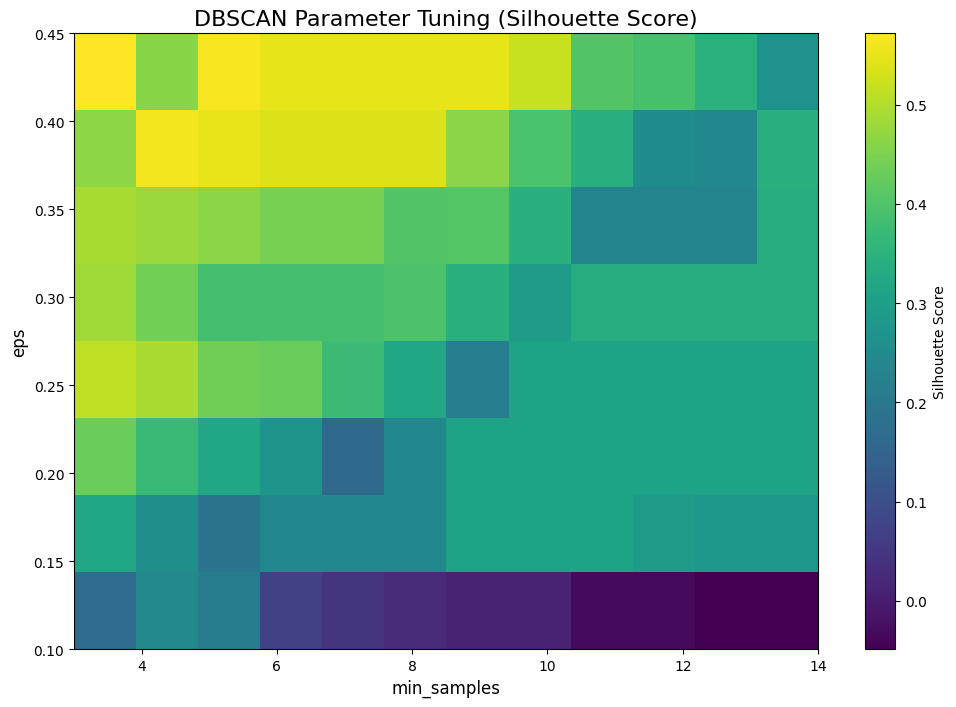

In [42]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.1, 0.5, 0.05)  # eps 범위
min_samples_values = range(3, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

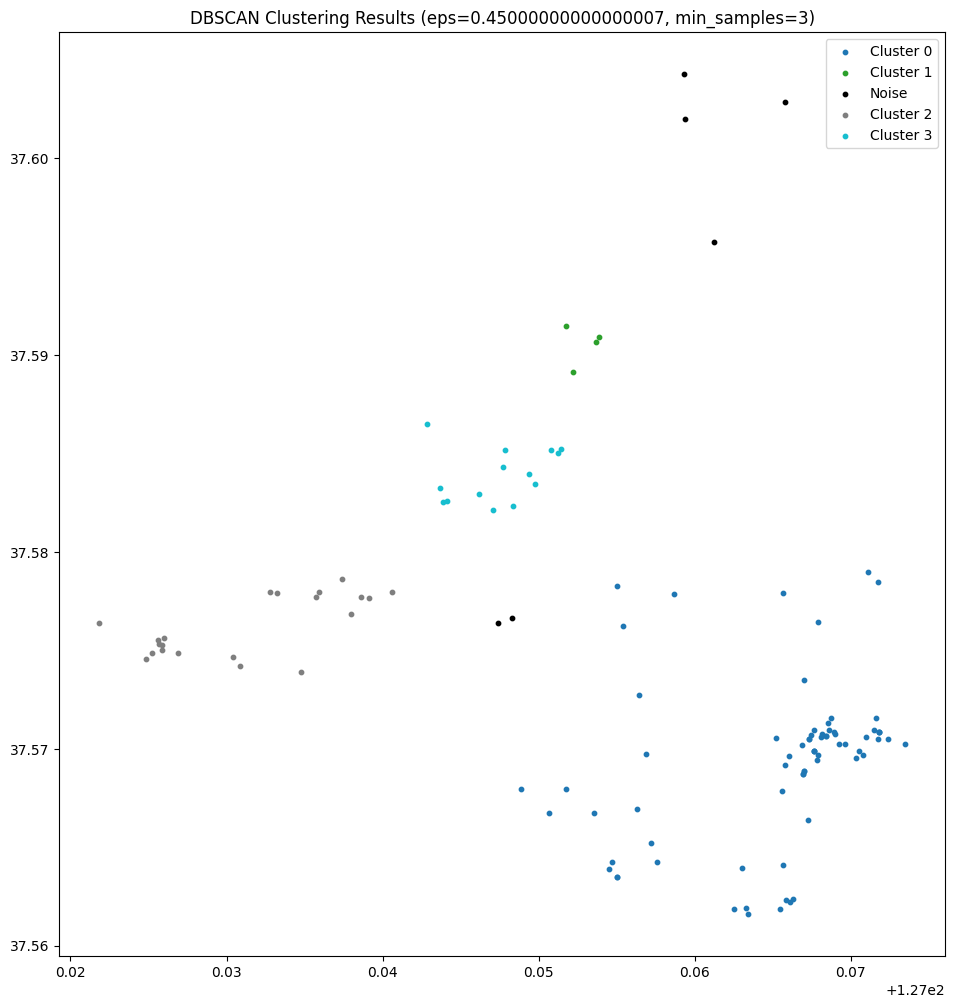

In [43]:
# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
alchohol_store_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = alchohol_store_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = alchohol_store_gdp[alchohol_store_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.09, Best min_samples: 4, Best silhouette score: 0.23057098942886012


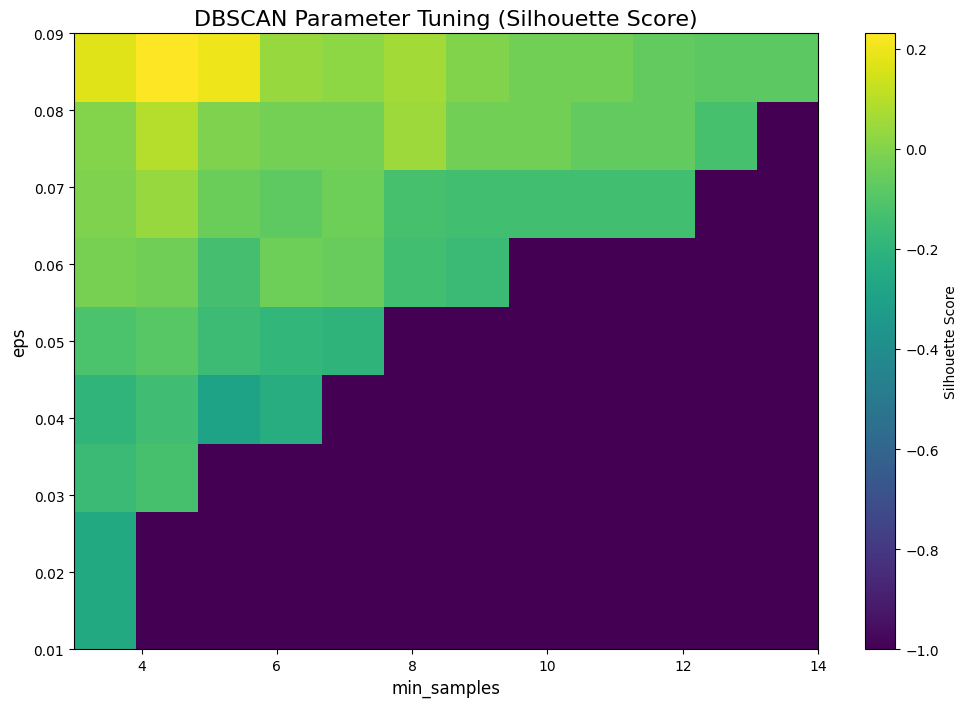

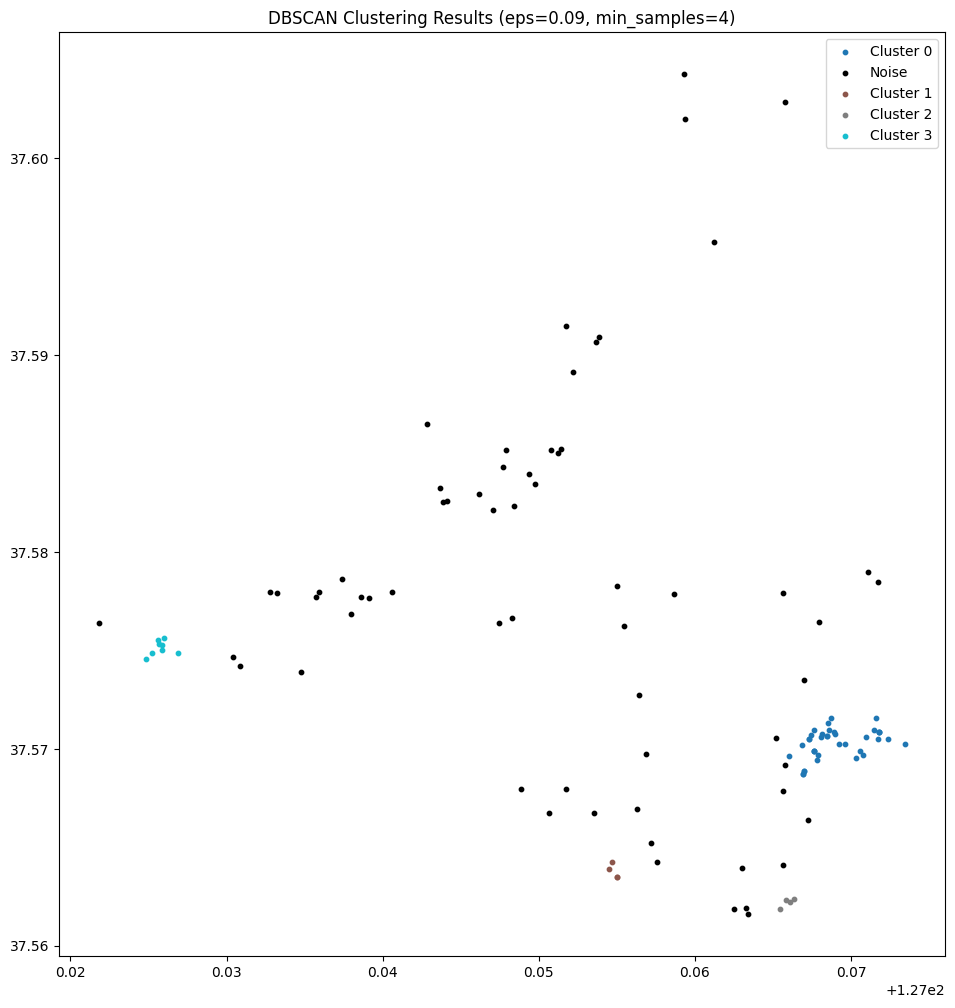

In [44]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.01, 0.1, 0.01)  # eps 범위
min_samples_values = range(3, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
alchohol_store_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = alchohol_store_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = alchohol_store_gdp[alchohol_store_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.17999999999999997, Best min_samples: 3, Best silhouette score: 0.38969026787470773


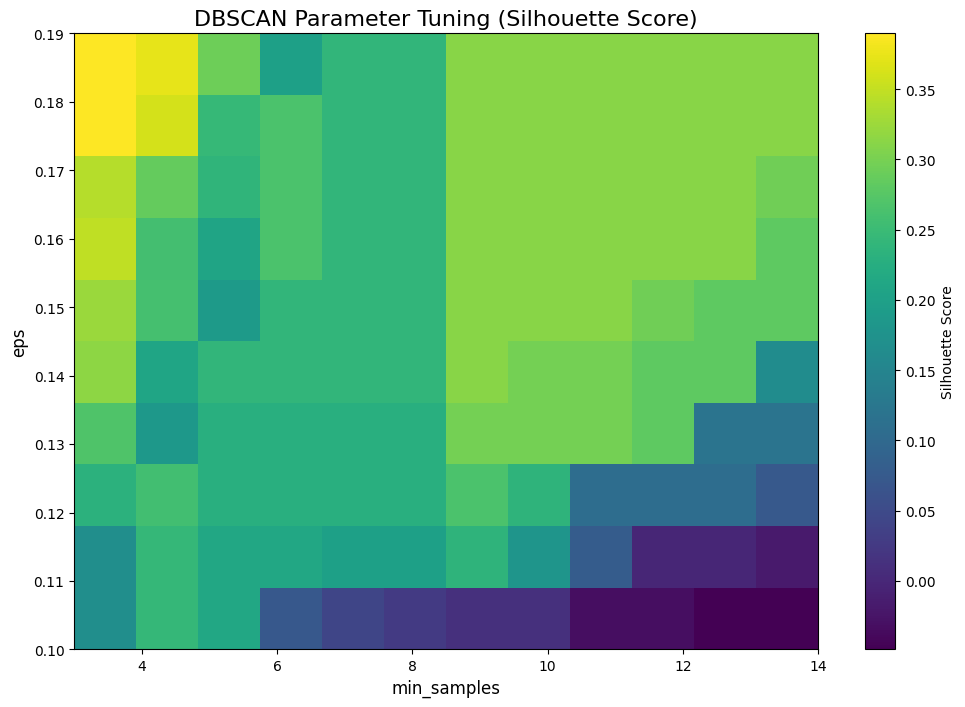

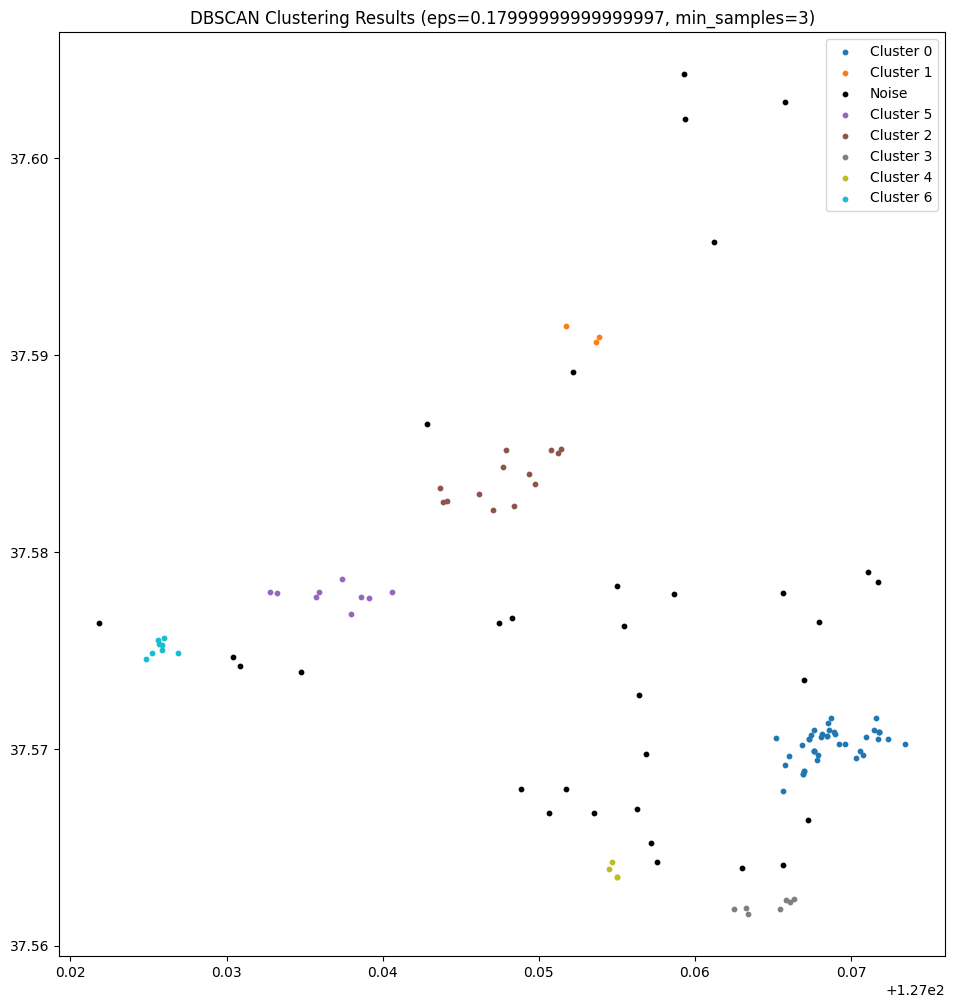

In [45]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.1, 0.2, 0.01)  # eps 범위
min_samples_values = range(3, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
alchohol_store_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = alchohol_store_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = alchohol_store_gdp[alchohol_store_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.2900000000000001, Best min_samples: 3, Best silhouette score: 0.5512938498298144


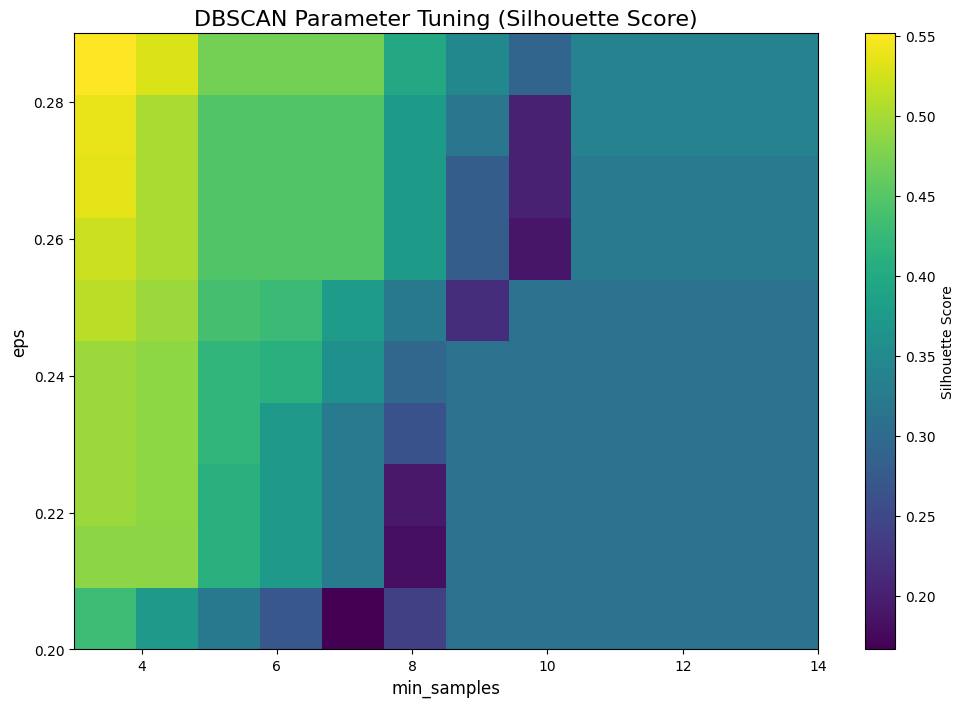

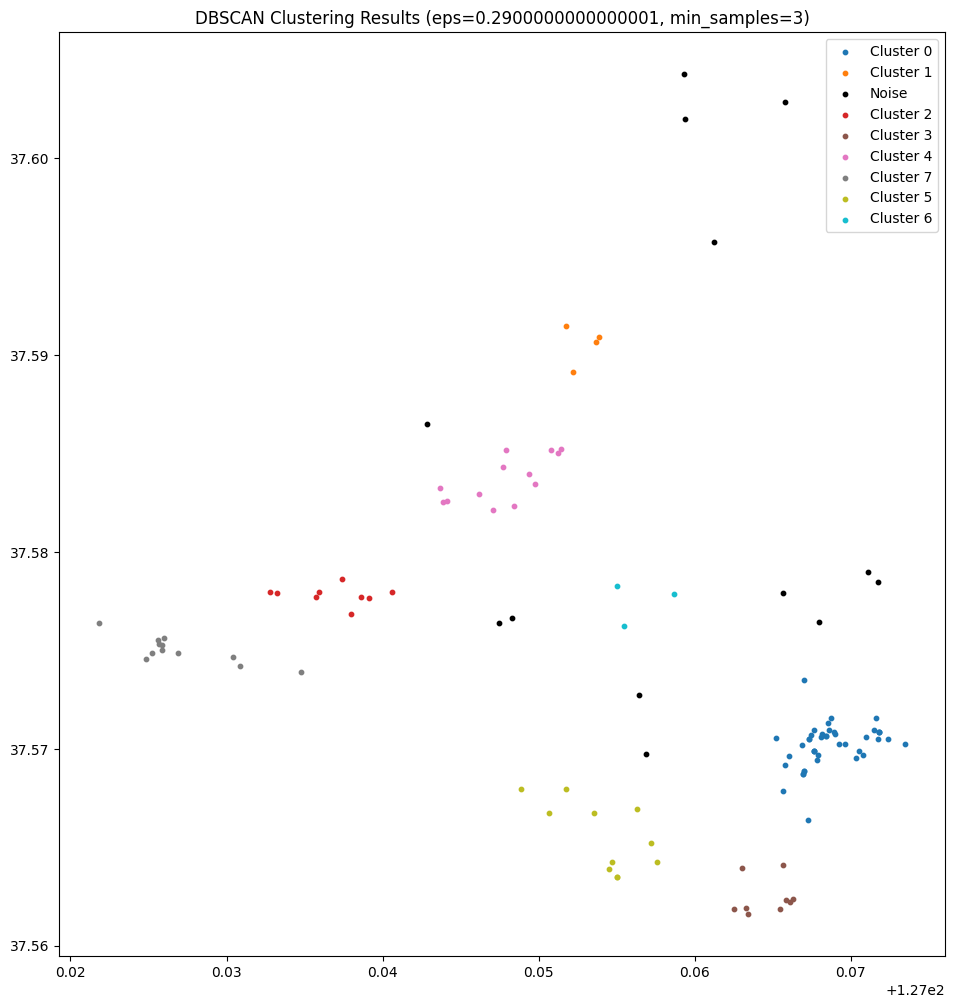

In [46]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.2, 0.3, 0.01)  # eps 범위
min_samples_values = range(3, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
alchohol_store_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = alchohol_store_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = alchohol_store_gdp[alchohol_store_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.39000000000000007, Best min_samples: 4, Best silhouette score: 0.5595401992635947


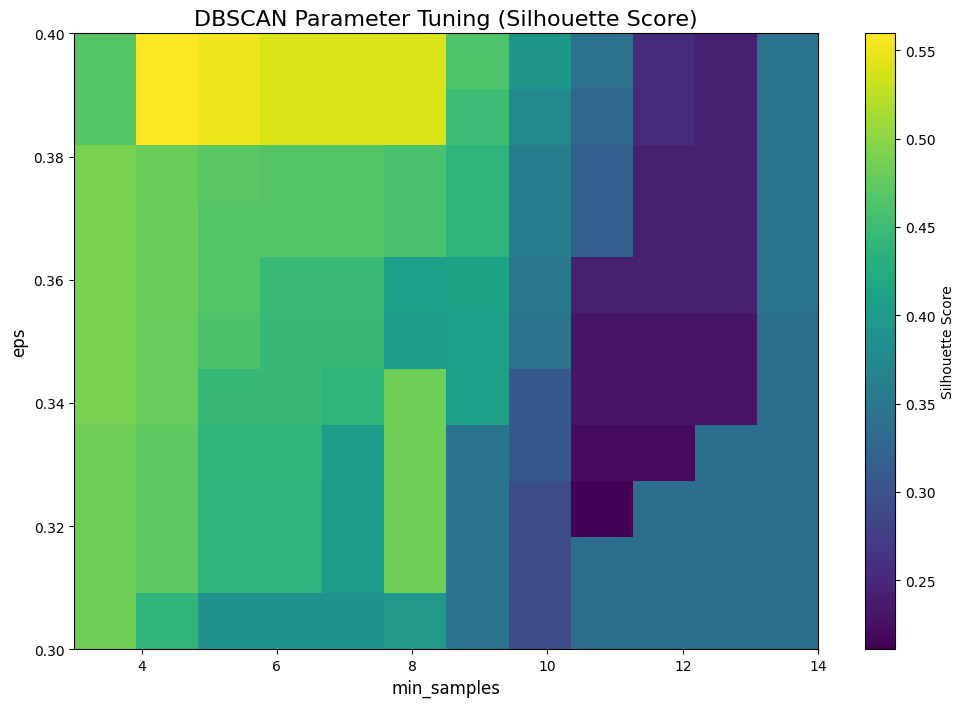

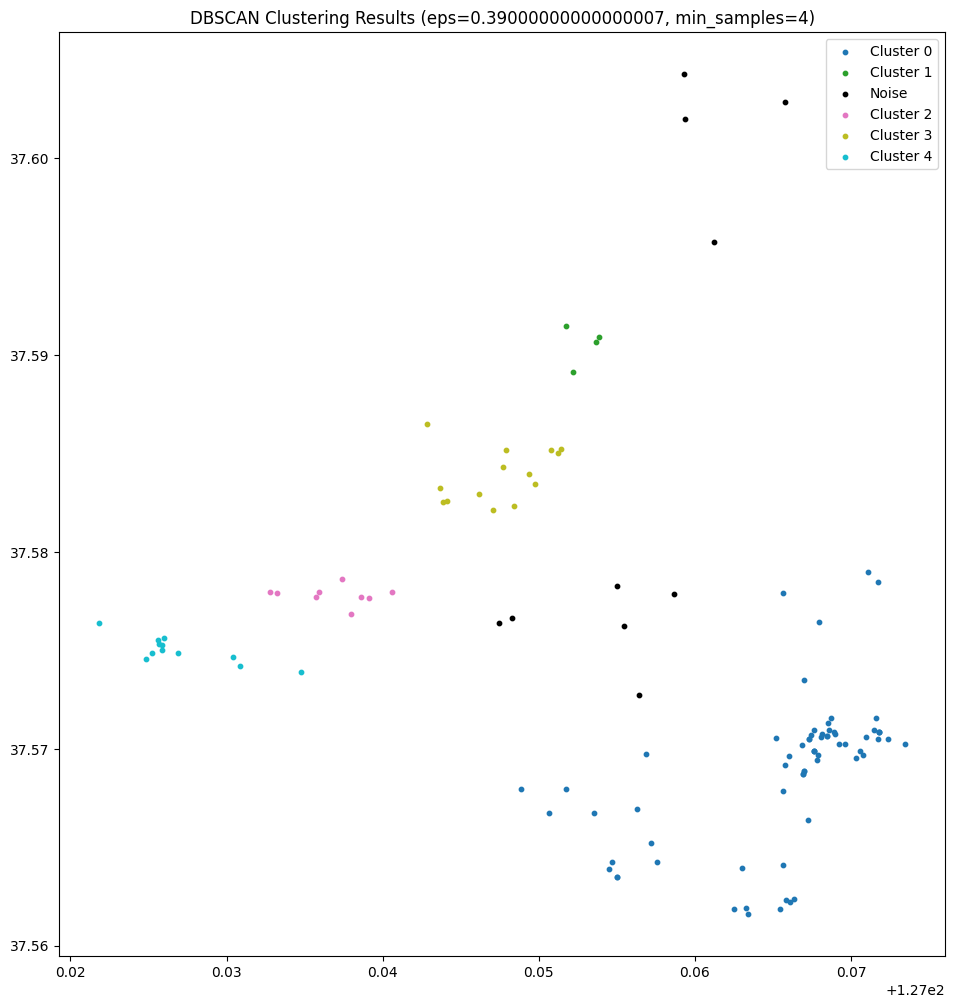

In [47]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.3, 0.4, 0.01)  # eps 범위
min_samples_values = range(3, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
alchohol_store_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = alchohol_store_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = alchohol_store_gdp[alchohol_store_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.4700000000000001, Best min_samples: 5, Best silhouette score: 0.5949774439148647


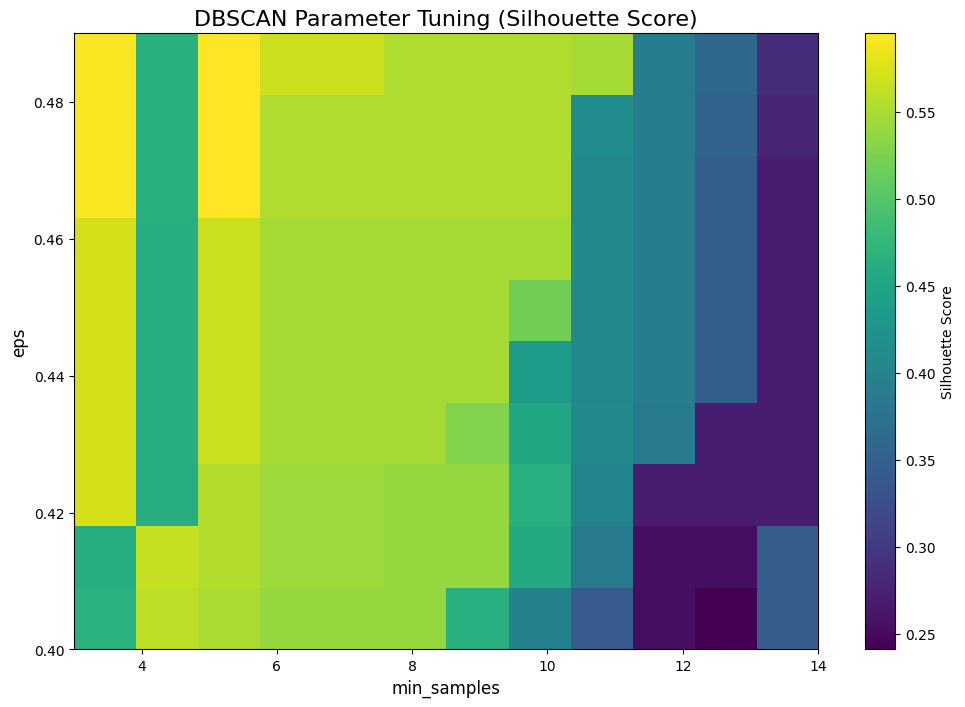

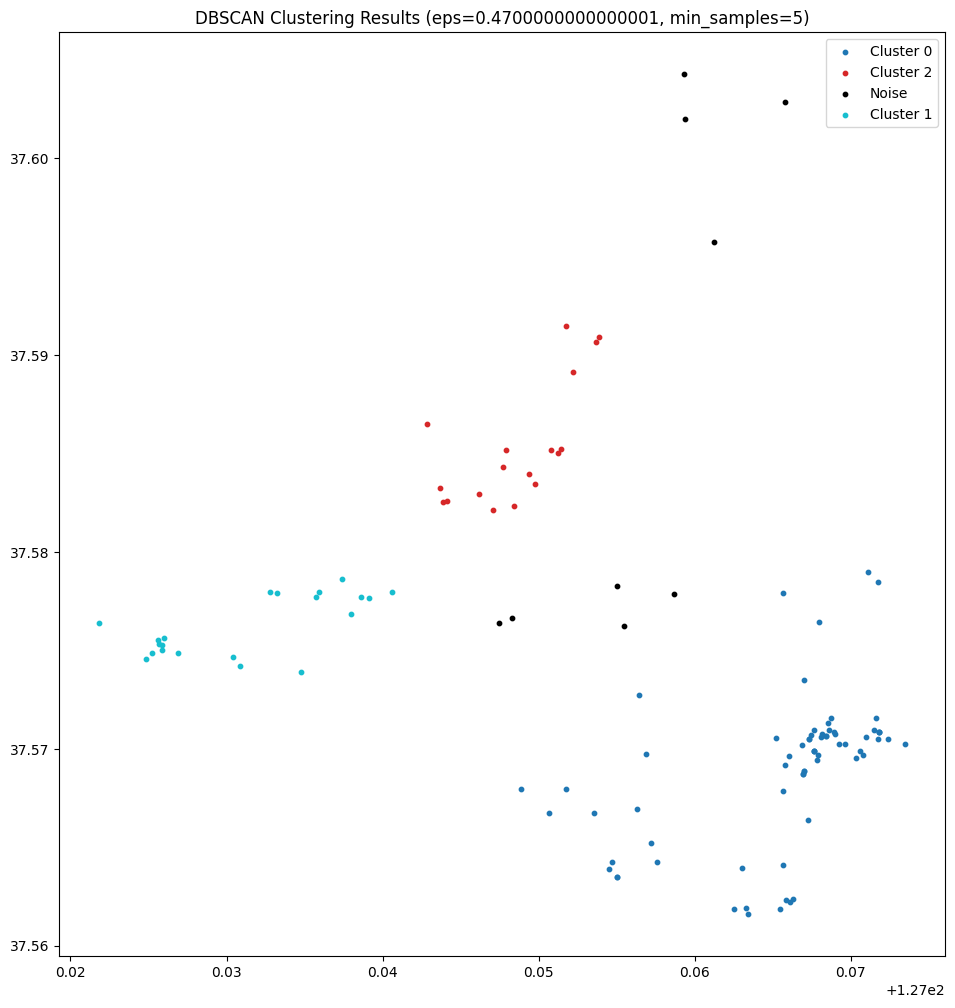

In [48]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.4, 0.5, 0.01)  # eps 범위
min_samples_values = range(3, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
alchohol_store_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = alchohol_store_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = alchohol_store_gdp[alchohol_store_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.2900000000000001, Best min_samples: 3, Best silhouette score: 0.5512938498298144
가 제일 적절해보인다.

In [49]:
# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = 0.2900000000000001, 3
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
alchohol_store_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

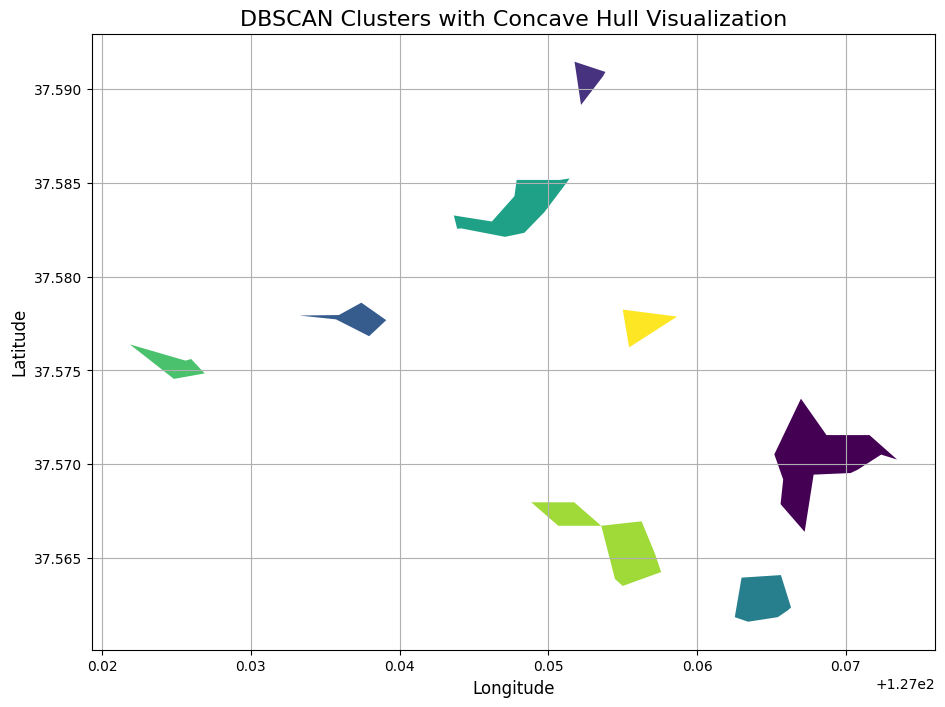

In [50]:
# Concave Hull 계산
cluster_rows = []

for cluster in alchohol_store_gdp['cluster'].unique():
    if cluster == -1:  # Noise는 제외
        continue

    # 특정 클러스터에 속하는 데이터 필터링
    cluster_data = alchohol_store_gdp[alchohol_store_gdp['cluster'] == cluster]

    # 해당 클러스터의 Concave Hull 계산
    coords = list(zip(cluster_data.geometry.x, cluster_data.geometry.y))

    # Alpha Shape을 사용하여 Concave Hull 생성
    concave_hull = alphashape.alphashape(coords, alpha=500)  # alpha 값 조정 가능

    # Concave Hull 정보 저장
    cluster_rows.append({'cluster': cluster, 'geometry': concave_hull})

# Concave Hull을 포함한 GeoDataFrame 생성
gdf_clusters = gpd.GeoDataFrame(cluster_rows, columns=['cluster', 'geometry'], crs=alchohol_store_gdp.crs)

# Concave Hull geometries 시각화
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_clusters.plot(ax=ax, cmap='viridis', legend=True)
plt.title('DBSCAN Clusters with Concave Hull Visualization', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True)
plt.show()


In [51]:
output_path = "/content/drive/MyDrive/bigdata/dataset/전처리 완료/취객 dbscan.geojson"
gdf_clusters.to_file(output_path, driver="GeoJSON")

## 상습불법주정차

In [52]:
# 상습불법주정차 데이터 읽기
dir_path = "/content/drive/MyDrive/bigdata/dataset/전처리 완료"
file_name = "상습불법주정차위치.csv"
illegal_parking = pd.read_csv(f"{dir_path}/{file_name}")

# 상습불법주정차 데이터를 GeoDataFrame으로 변환 (EPSG:4326)
geometry = [Point(xy) for xy in zip(illegal_parking['x'], illegal_parking['y'])]
illegal_parking_gdp = gpd.GeoDataFrame(illegal_parking, geometry=geometry, crs="EPSG:4326")

# 좌표 데이터 준비
coords = np.array(list(zip(illegal_parking_gdp.geometry.x, illegal_parking_gdp.geometry.y)))

# 좌표 스케일링
coords_scaled = StandardScaler().fit_transform(coords)


Best eps: 0.06999999999999999, Best min_samples: 7, Best silhouette score: 0.2911462152943648


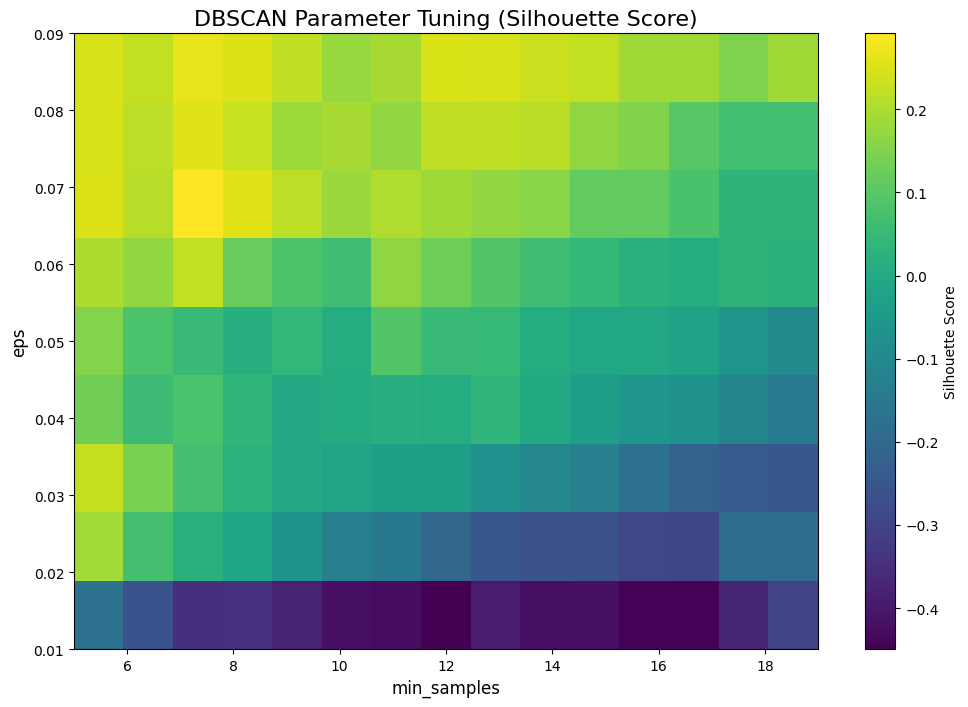

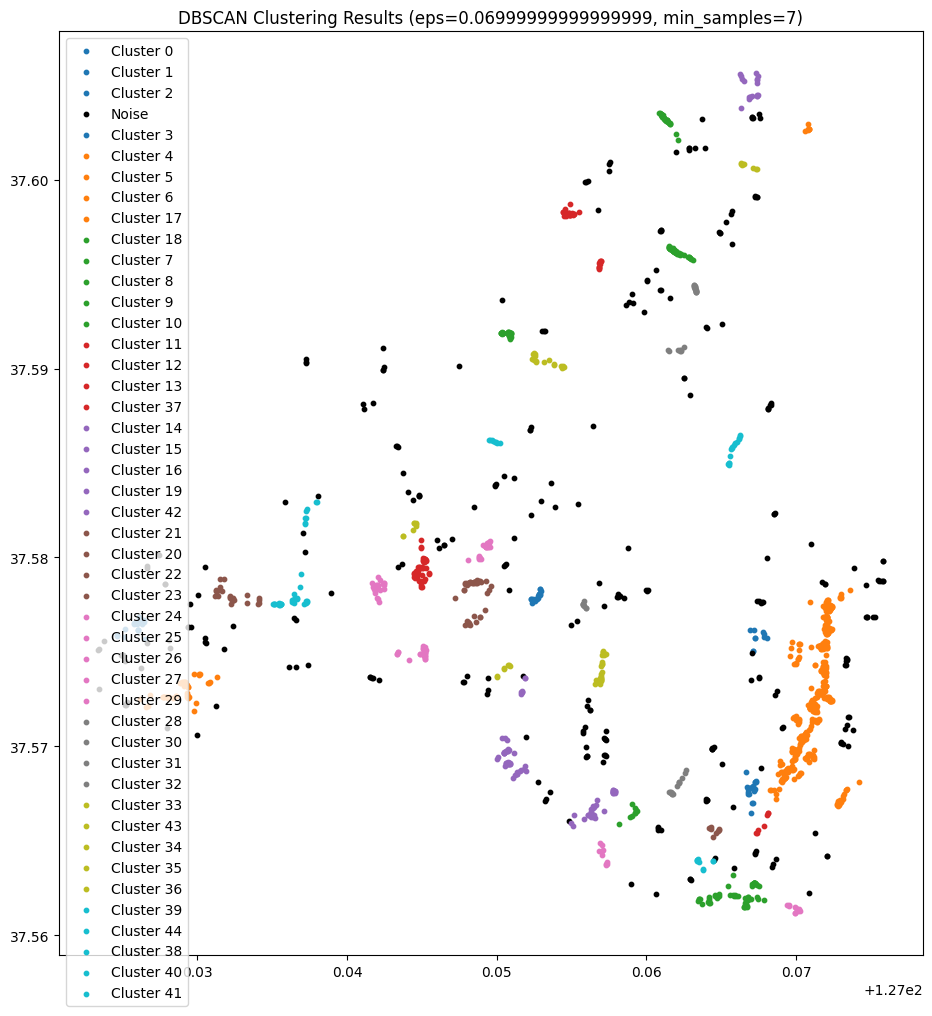

In [53]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.01, 0.1, 0.01)  # eps 범위
min_samples_values = range(5, 20, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
illegal_parking_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = illegal_parking_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = illegal_parking_gdp[illegal_parking_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.15999999999999998, Best min_samples: 19, Best silhouette score: 0.39341421786478237


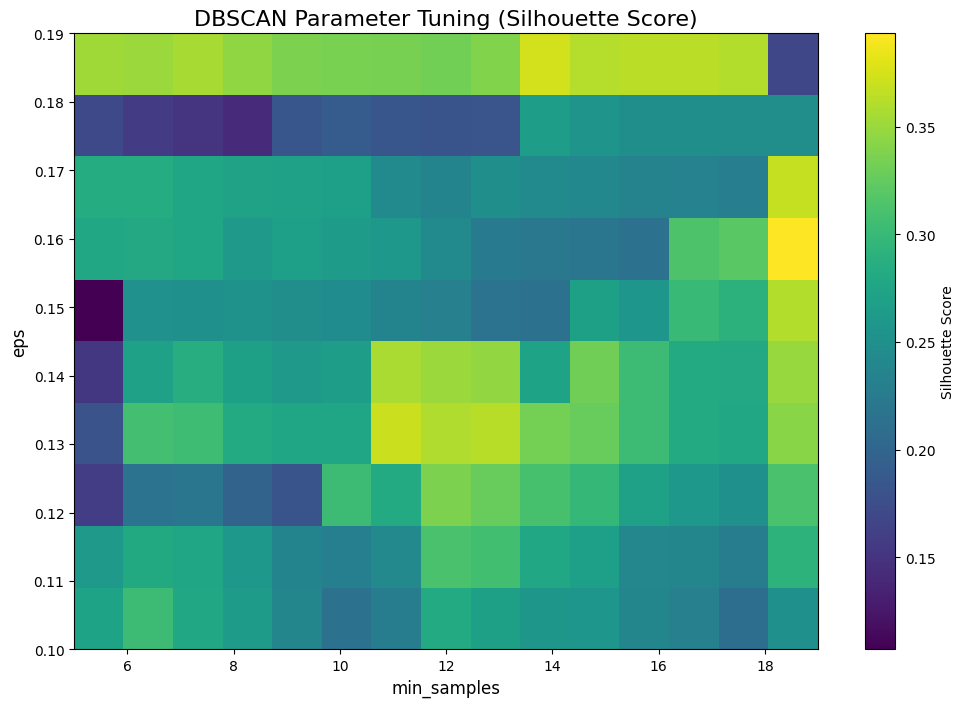

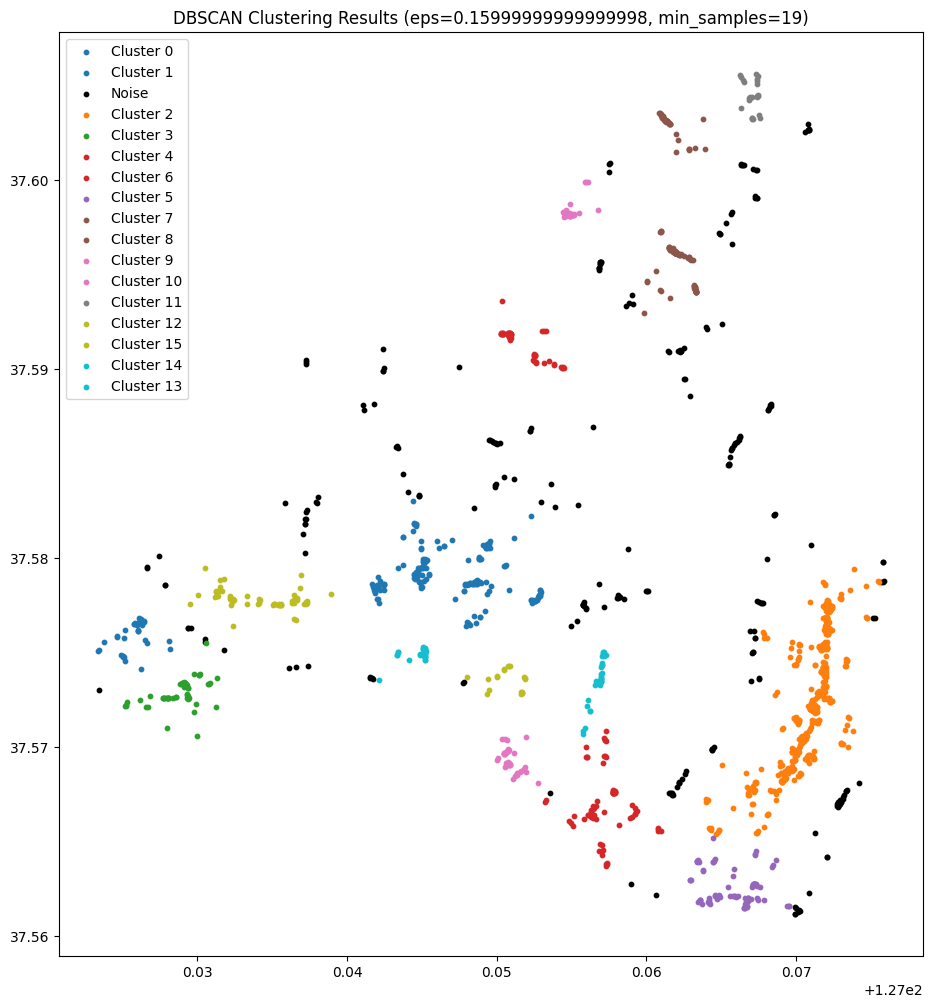

In [54]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.1, 0.2, 0.01)  # eps 범위
min_samples_values = range(5, 20, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
illegal_parking_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = illegal_parking_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = illegal_parking_gdp[illegal_parking_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.2, Best min_samples: 19, Best silhouette score: 0.3655663371862219


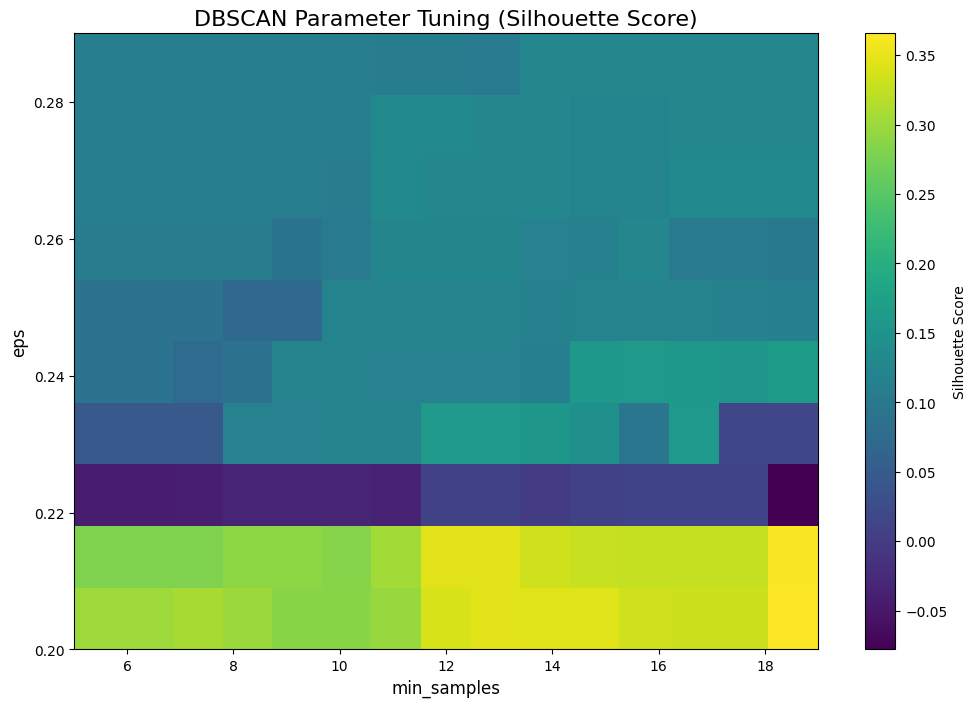

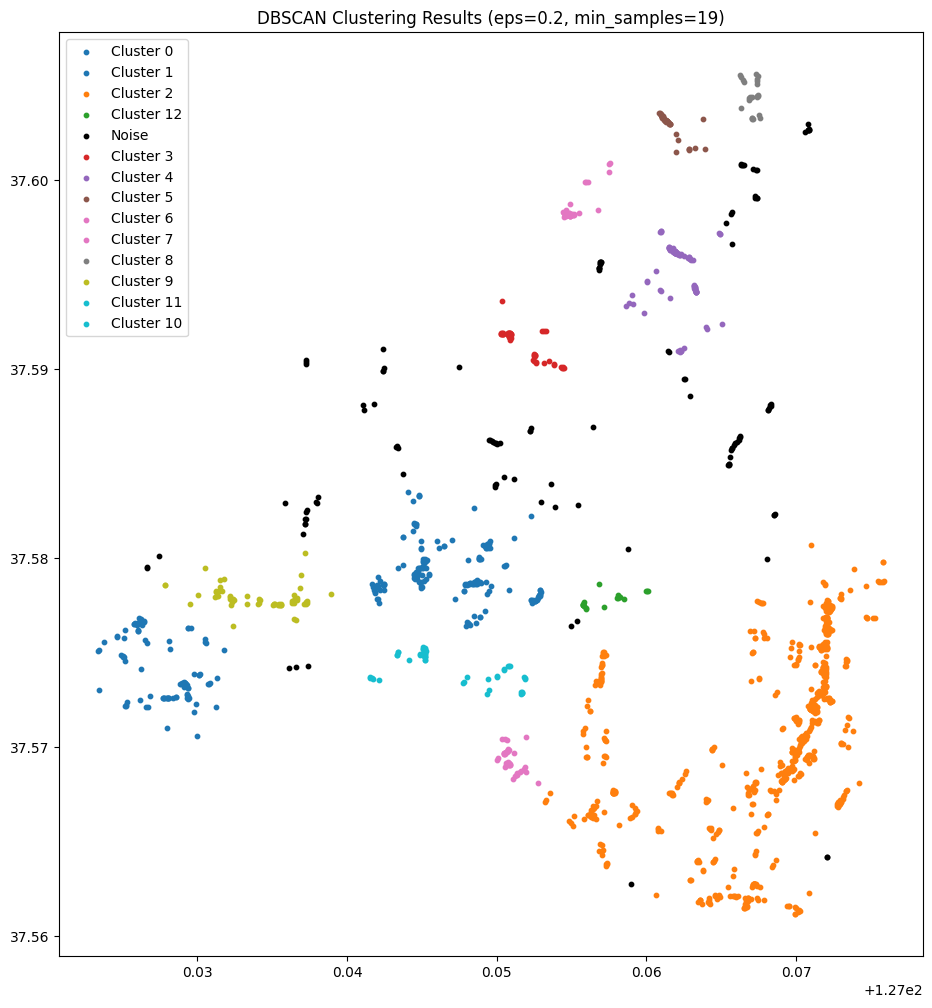

In [55]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.2, 0.3, 0.01)  # eps 범위
min_samples_values = range(5, 20, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
illegal_parking_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = illegal_parking_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = illegal_parking_gdp[illegal_parking_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.37000000000000005, Best min_samples: 11, Best silhouette score: 0.4318872577572312


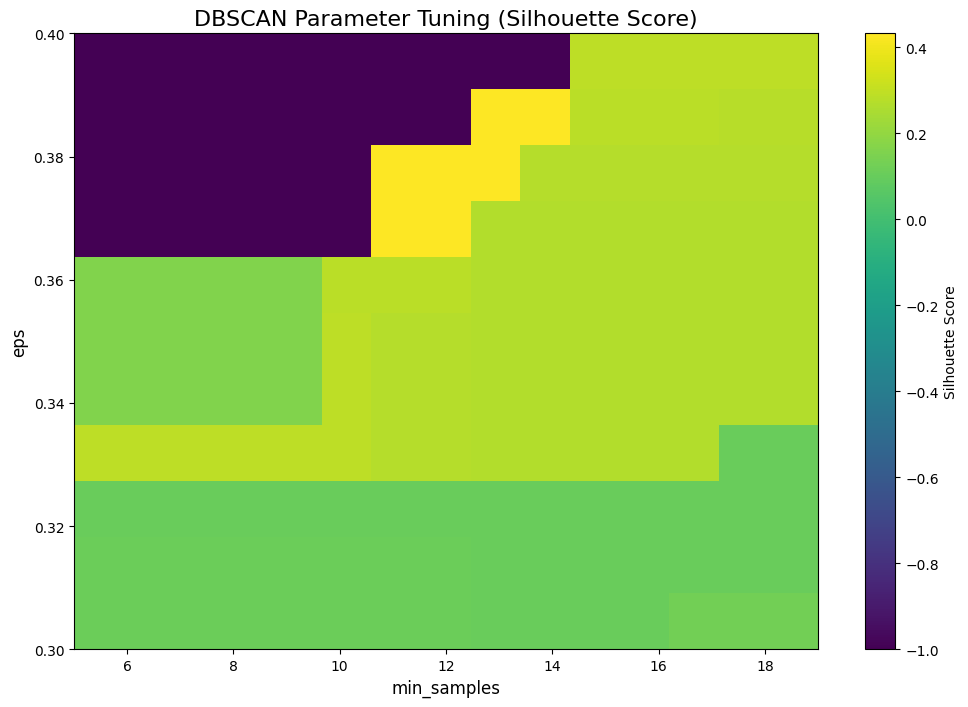

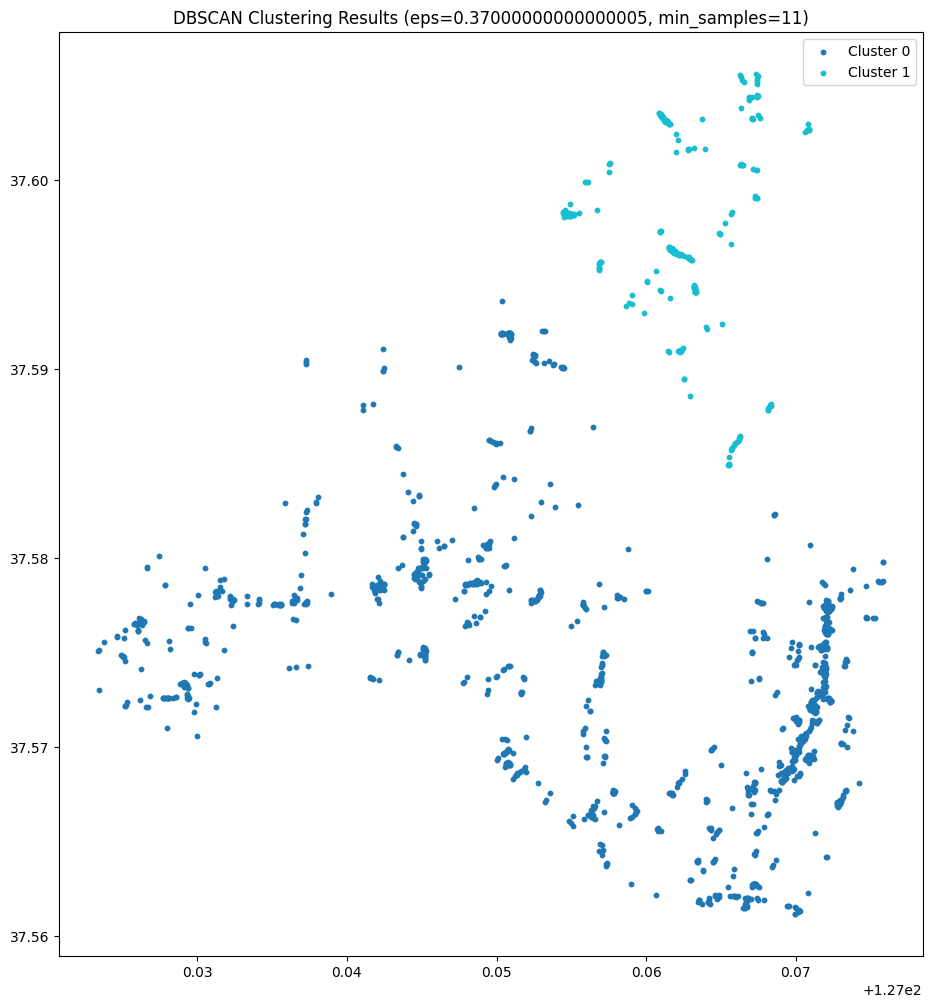

In [56]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.3, 0.4, 0.01)  # eps 범위
min_samples_values = range(5, 20, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
illegal_parking_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = illegal_parking_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = illegal_parking_gdp[illegal_parking_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.06999999999999999, Best min_samples: 7, Best silhouette score: 0.2911462152943648



이 제일 나아보인다.

In [57]:
# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = 0.06999999999999999, 7
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
illegal_parking_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

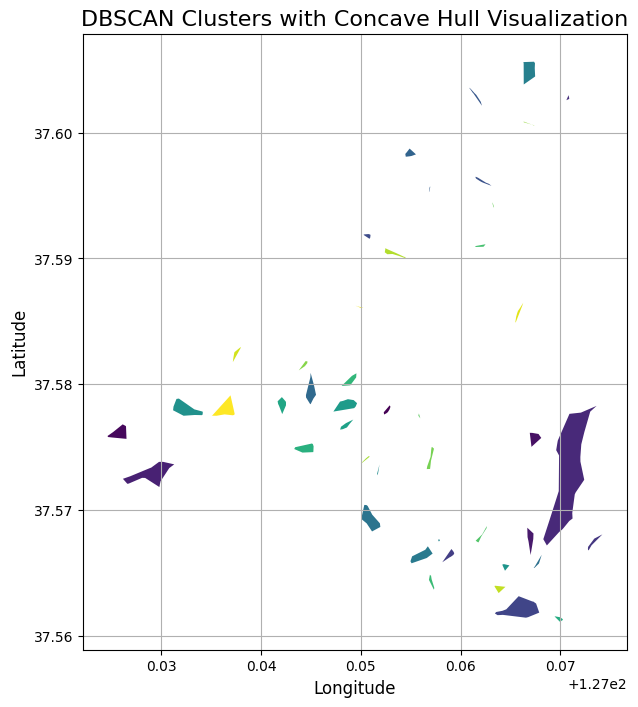

In [58]:
# Concave Hull 계산
cluster_rows = []

for cluster in illegal_parking_gdp['cluster'].unique():
    if cluster == -1:  # Noise는 제외
        continue

    # 특정 클러스터에 속하는 데이터 필터링
    cluster_data = illegal_parking_gdp[illegal_parking_gdp['cluster'] == cluster]

    # 해당 클러스터의 Concave Hull 계산
    coords = list(zip(cluster_data.geometry.x, cluster_data.geometry.y))

    # Alpha Shape을 사용하여 Concave Hull 생성
    concave_hull = alphashape.alphashape(coords, alpha=500)  # alpha 값 조정 가능

    # Concave Hull 정보 저장
    cluster_rows.append({'cluster': cluster, 'geometry': concave_hull})

# Concave Hull을 포함한 GeoDataFrame 생성
gdf_clusters = gpd.GeoDataFrame(cluster_rows, columns=['cluster', 'geometry'], crs=illegal_parking_gdp.crs)

# Concave Hull geometries 시각화
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_clusters.plot(ax=ax, cmap='viridis', legend=True)
plt.title('DBSCAN Clusters with Concave Hull Visualization', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True)
plt.show()


In [59]:
output_path = "/content/drive/MyDrive/bigdata/dataset/전처리 완료/상습불법주정차 dbscan.geojson"
gdf_clusters.to_file(output_path, driver="GeoJSON")

## 노후주택

In [60]:
# 취객 데이터 읽기
dir_path = "/content/drive/MyDrive/bigdata/dataset/전처리 완료"
file_name = "노후주택 최종데이터.csv"
old_architecture = pd.read_csv(f"{dir_path}/{file_name}")

# 취객 데이터를 GeoDataFrame으로 변환 (EPSG:4326)
geometry = [Point(xy) for xy in zip(old_architecture['x'], old_architecture['y'])]
old_architecture_gdp = gpd.GeoDataFrame(old_architecture, geometry=geometry, crs="EPSG:4326")

# 좌표 데이터 준비
coords = np.array(list(zip(old_architecture_gdp.geometry.x, old_architecture_gdp.geometry.y)))

# 좌표 스케일링
coords_scaled = StandardScaler().fit_transform(coords)


Best eps: 0.060000000000000005, Best min_samples: 10, Best silhouette score: 0.11158606229443796


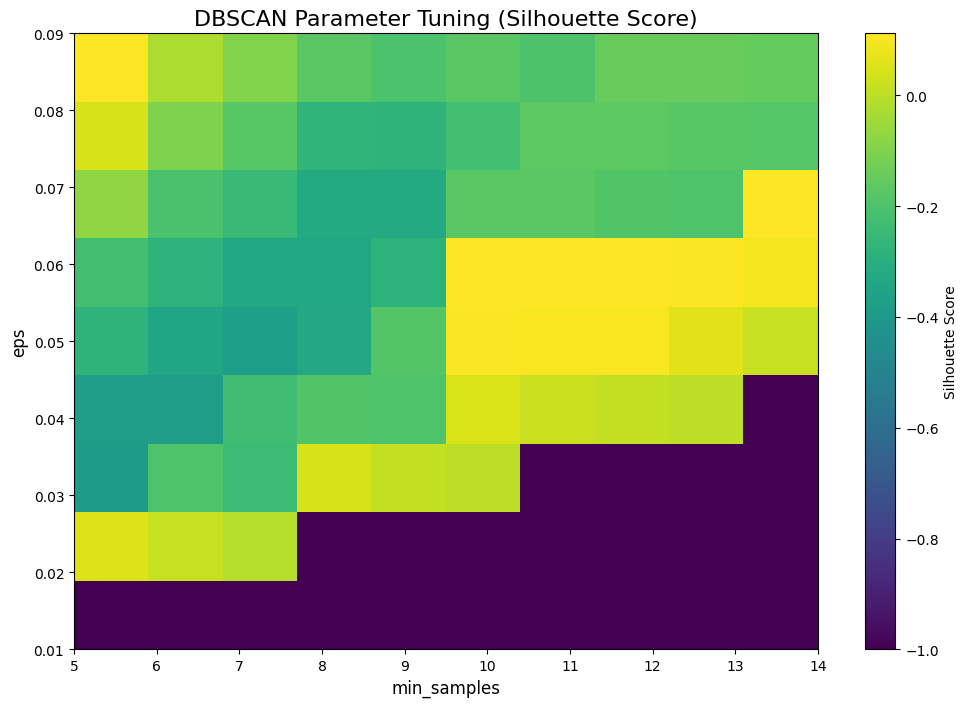

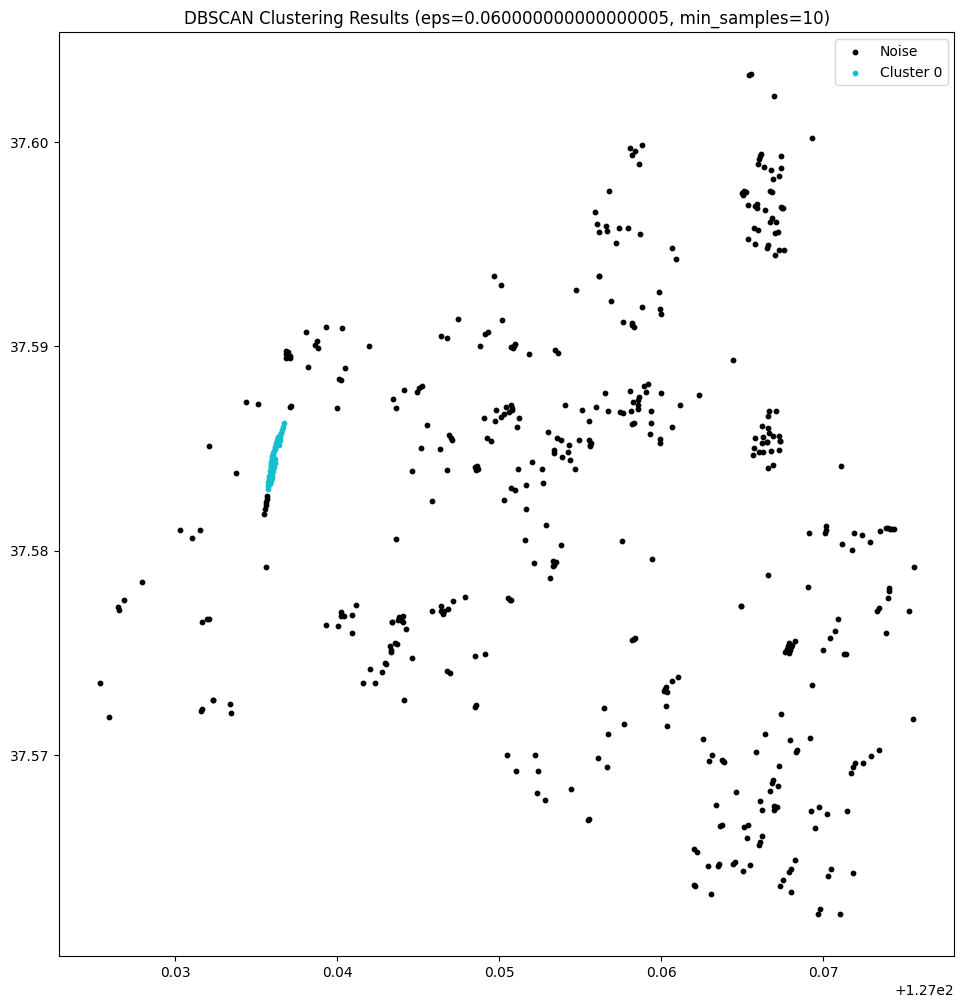

In [61]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.01, 0.1, 0.01)  # eps 범위
min_samples_values = range(5, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
old_architecture_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = old_architecture_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = old_architecture_gdp[old_architecture_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.18999999999999995, Best min_samples: 5, Best silhouette score: 0.3353214980582083


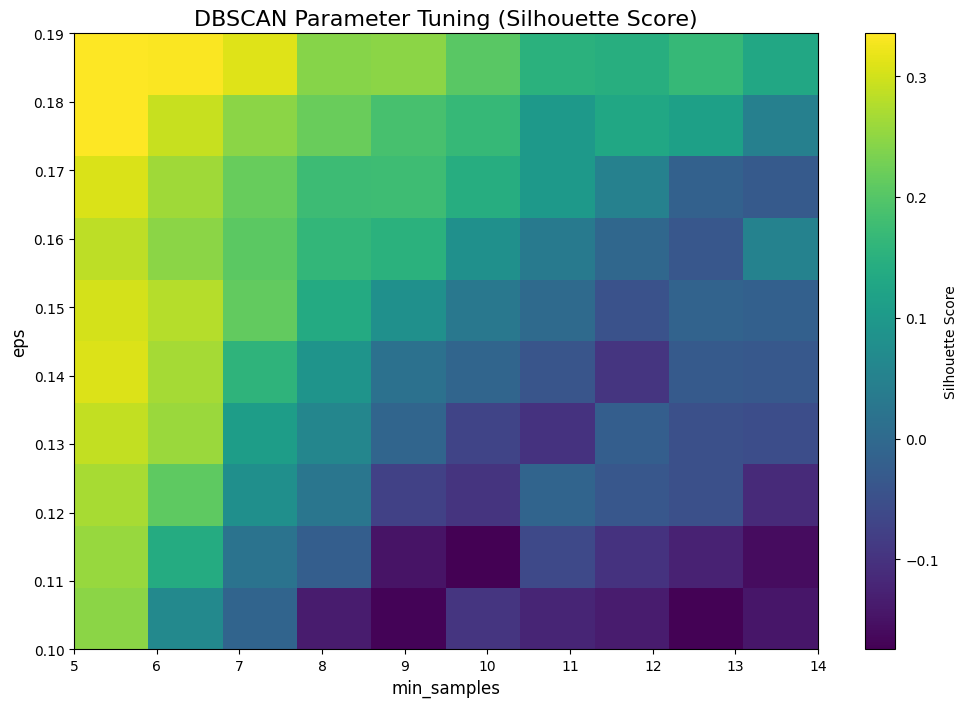

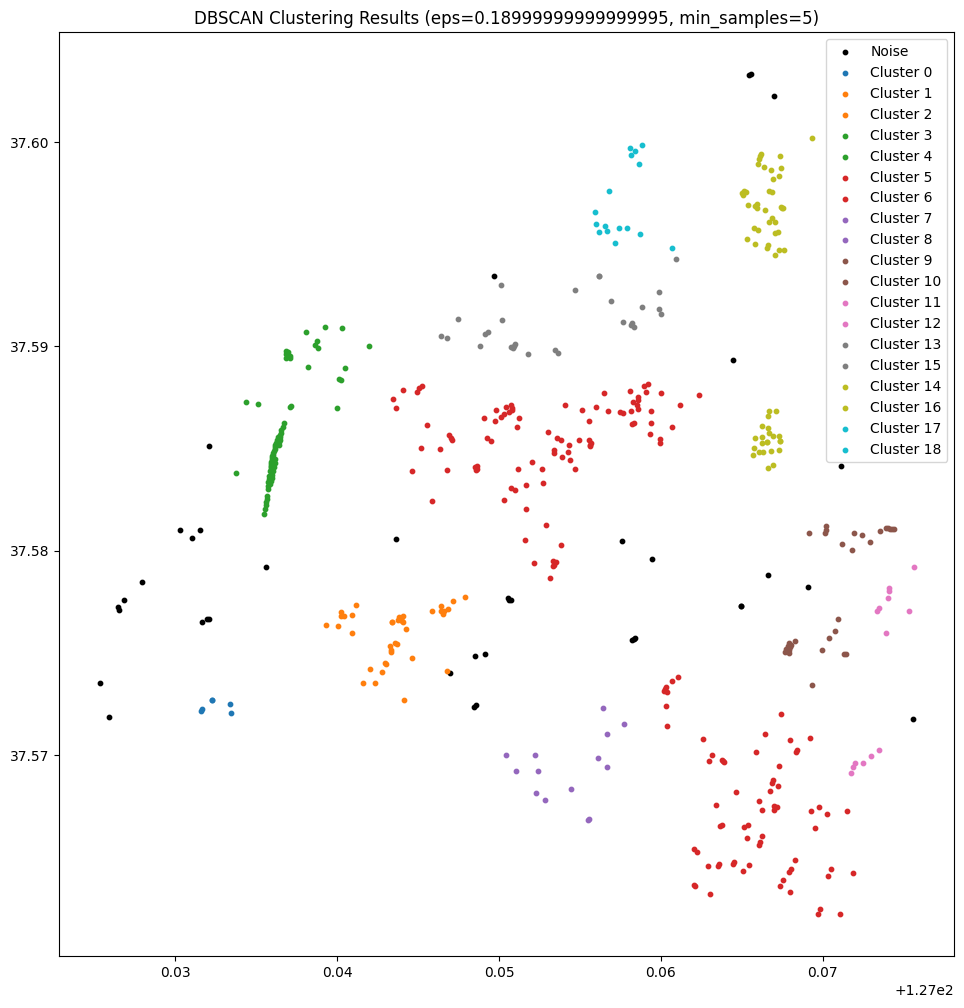

In [62]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.1, 0.2, 0.01)  # eps 범위
min_samples_values = range(5, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
old_architecture_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = old_architecture_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = old_architecture_gdp[old_architecture_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.2700000000000001, Best min_samples: 10, Best silhouette score: 0.3968264938838738


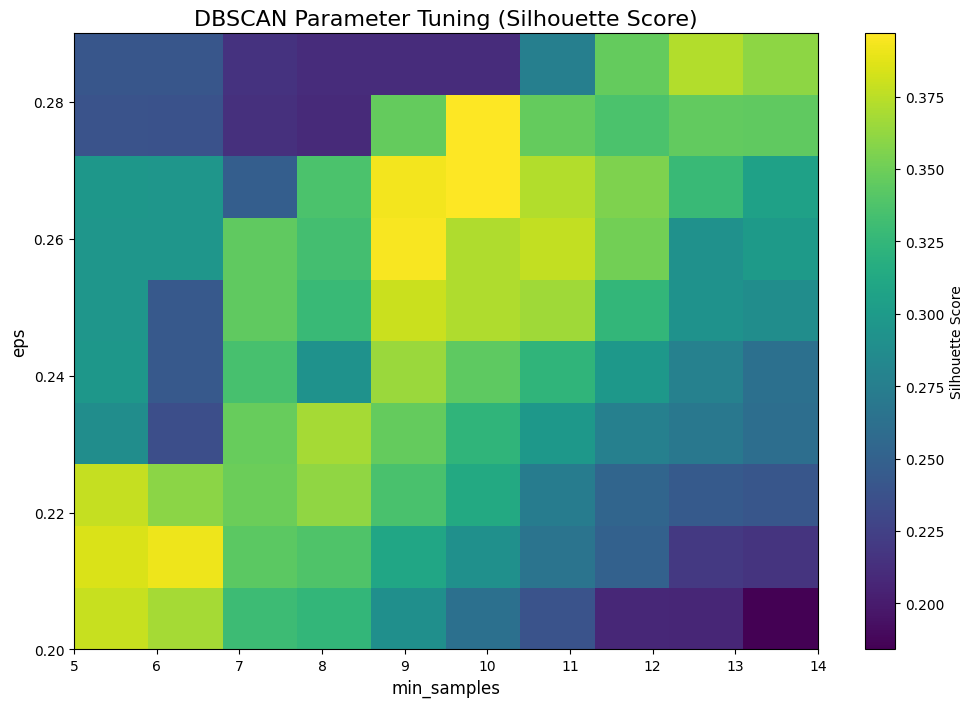

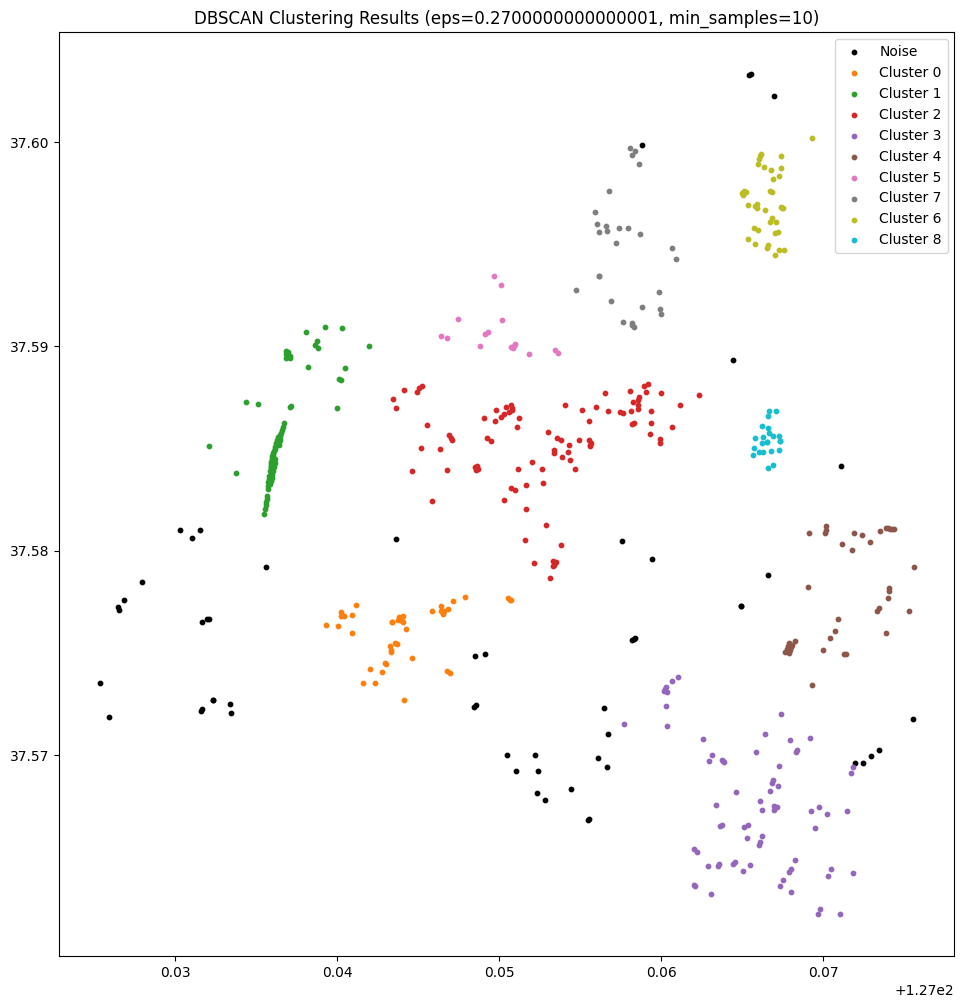

In [63]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.2, 0.3, 0.01)  # eps 범위
min_samples_values = range(5, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
old_architecture_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = old_architecture_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = old_architecture_gdp[old_architecture_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.31, Best min_samples: 14, Best silhouette score: 0.38650327738749146


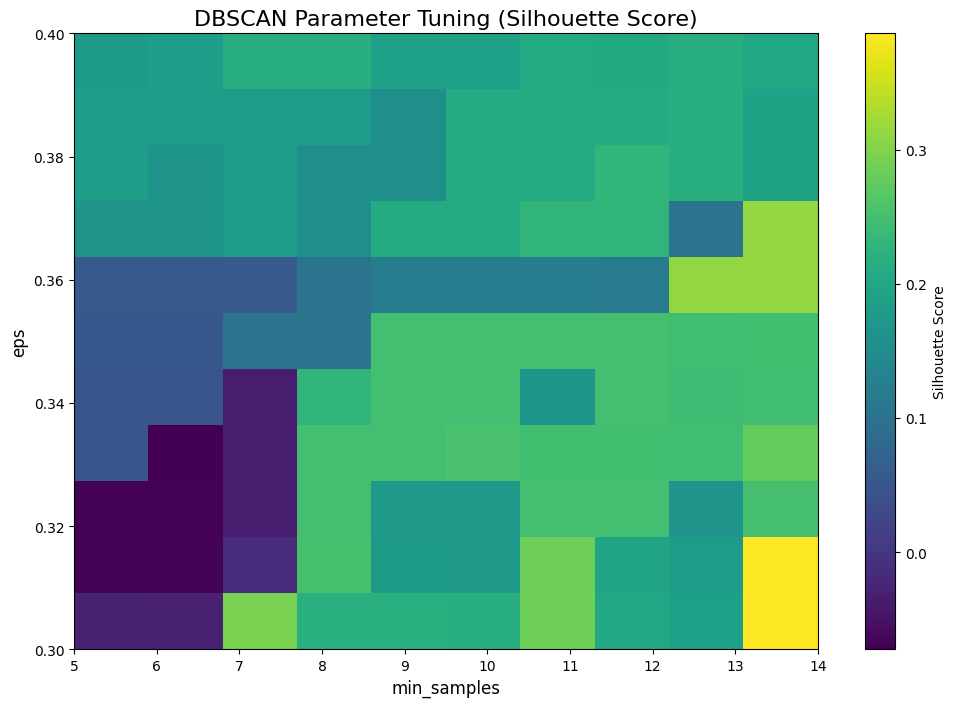

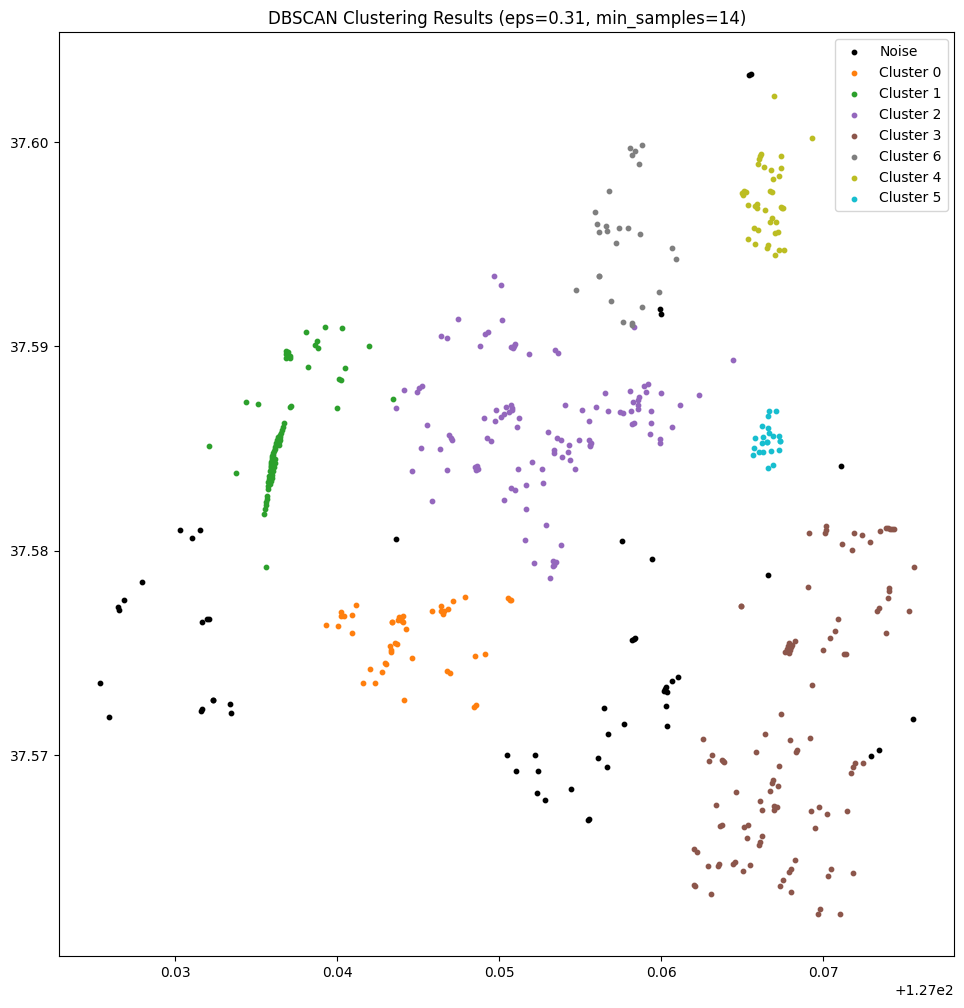

In [64]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.3, 0.4, 0.01)  # eps 범위
min_samples_values = range(5, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
old_architecture_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = old_architecture_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = old_architecture_gdp[old_architecture_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.18999999999999995, Best min_samples: 5, Best silhouette score: 0.3353214980582083
가 제일 나아보인다.

In [65]:
# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = 0.18999999999999995, 5
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
old_architecture_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

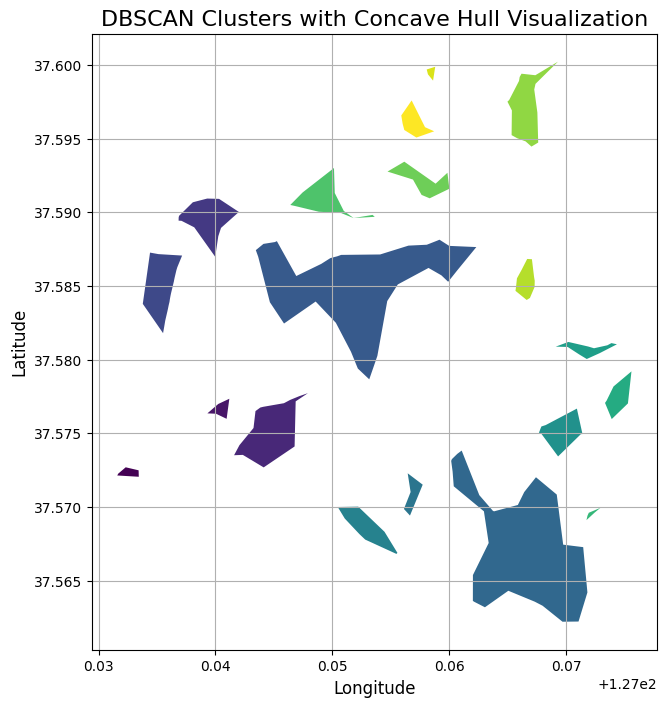

In [66]:
# Concave Hull 계산
cluster_rows = []

for cluster in old_architecture_gdp['cluster'].unique():
    if cluster == -1:  # Noise는 제외
        continue

    # 특정 클러스터에 속하는 데이터 필터링
    cluster_data = old_architecture_gdp[old_architecture_gdp['cluster'] == cluster]

    # 해당 클러스터의 Concave Hull 계산
    coords = list(zip(cluster_data.geometry.x, cluster_data.geometry.y))

    # Alpha Shape을 사용하여 Concave Hull 생성
    concave_hull = alphashape.alphashape(coords, alpha=500)  # alpha 값 조정 가능

    # Concave Hull 정보 저장
    cluster_rows.append({'cluster': cluster, 'geometry': concave_hull})

# Concave Hull을 포함한 GeoDataFrame 생성
gdf_clusters = gpd.GeoDataFrame(cluster_rows, columns=['cluster', 'geometry'], crs=old_architecture_gdp.crs)

# Concave Hull geometries 시각화
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_clusters.plot(ax=ax, cmap='viridis', legend=True)
plt.title('DBSCAN Clusters with Concave Hull Visualization', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True)
plt.show()


In [67]:
output_path = "/content/drive/MyDrive/bigdata/dataset/전처리 완료/노후주택 dbscan.geojson"
gdf_clusters.to_file(output_path, driver="GeoJSON")

## 유동인구


In [68]:
# 유동인구 데이터 읽기
dir_path = "/content/drive/MyDrive/bigdata/dataset/전처리 완료"
file_name = "유동인구.csv"
foot_traffic = pd.read_csv(f"{dir_path}/{file_name}")

# 유동인구 데이터를 GeoDataFrame으로 변환 (EPSG:4326)
geometry = [Point(xy) for xy in zip(foot_traffic['x'], foot_traffic['y'])]
foot_traffic_gdp = gpd.GeoDataFrame(foot_traffic, geometry=geometry, crs="EPSG:4326")

# 좌표 데이터 준비
coords = np.array(list(zip(foot_traffic_gdp.geometry.x, foot_traffic_gdp.geometry.y)))

# 좌표 스케일링
coords_scaled = StandardScaler().fit_transform(coords)


Best eps: 0.09, Best min_samples: 8, Best silhouette score: 0.4145062374580719


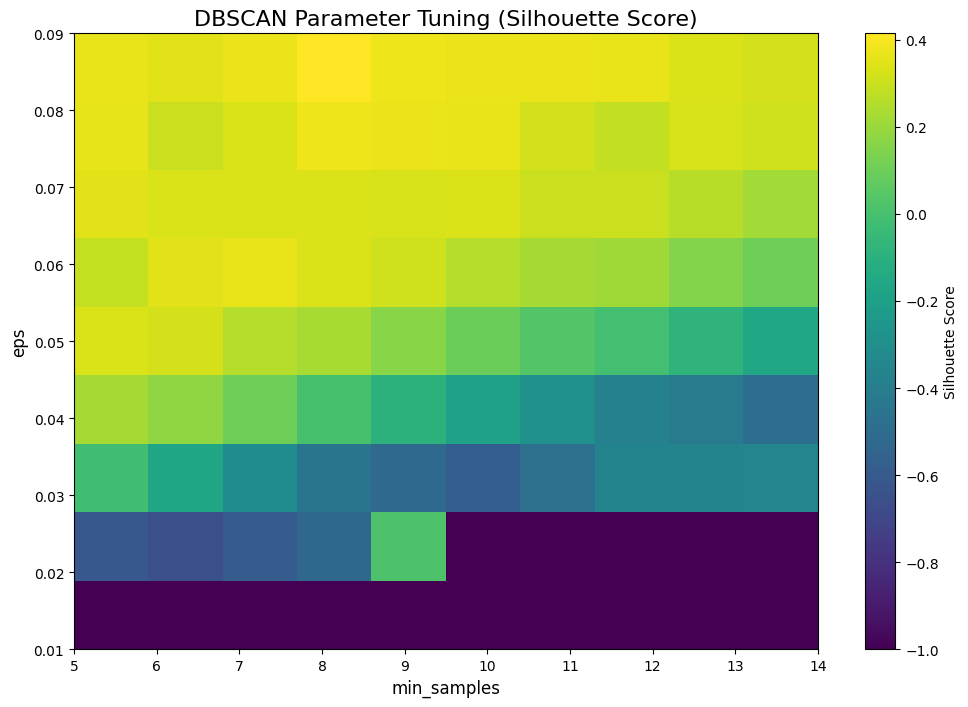

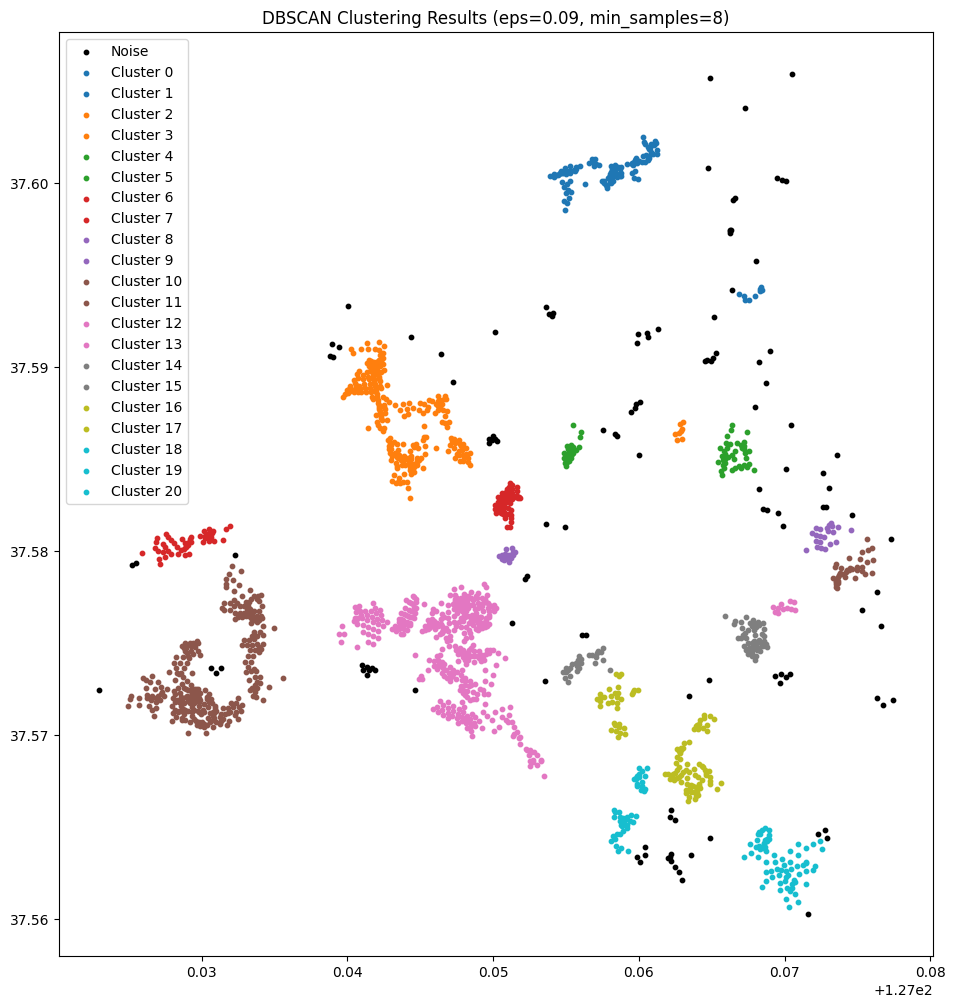

In [69]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.01, 0.1, 0.01)  # eps 범위
min_samples_values = range(5, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
foot_traffic_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = foot_traffic_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = foot_traffic_gdp[foot_traffic_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.14999999999999997, Best min_samples: 5, Best silhouette score: 0.5381561782667941


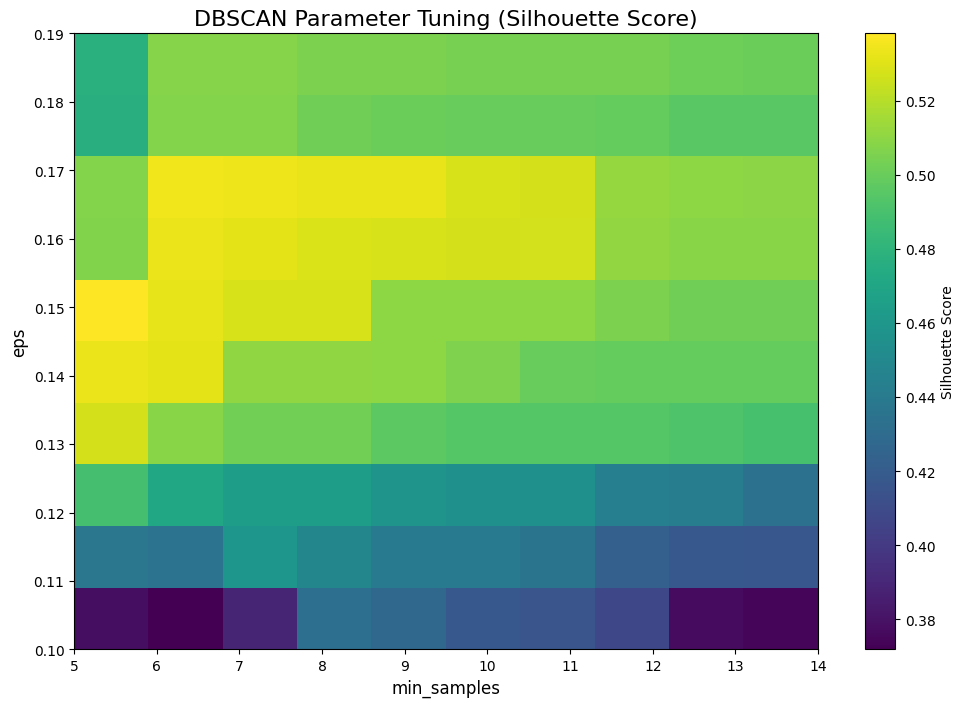

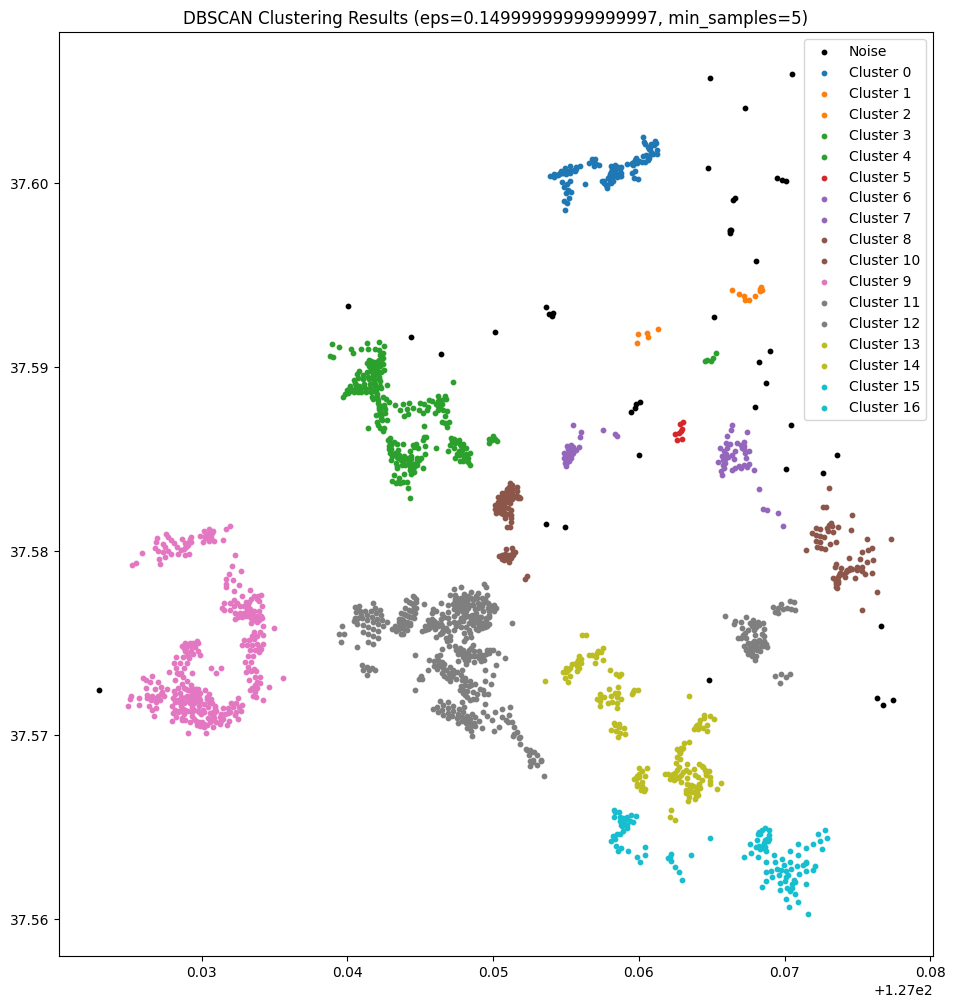

In [70]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.1, 0.2, 0.01)  # eps 범위
min_samples_values = range(5, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
foot_traffic_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = foot_traffic_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = foot_traffic_gdp[foot_traffic_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.23000000000000004, Best min_samples: 10, Best silhouette score: 0.5286244080634896


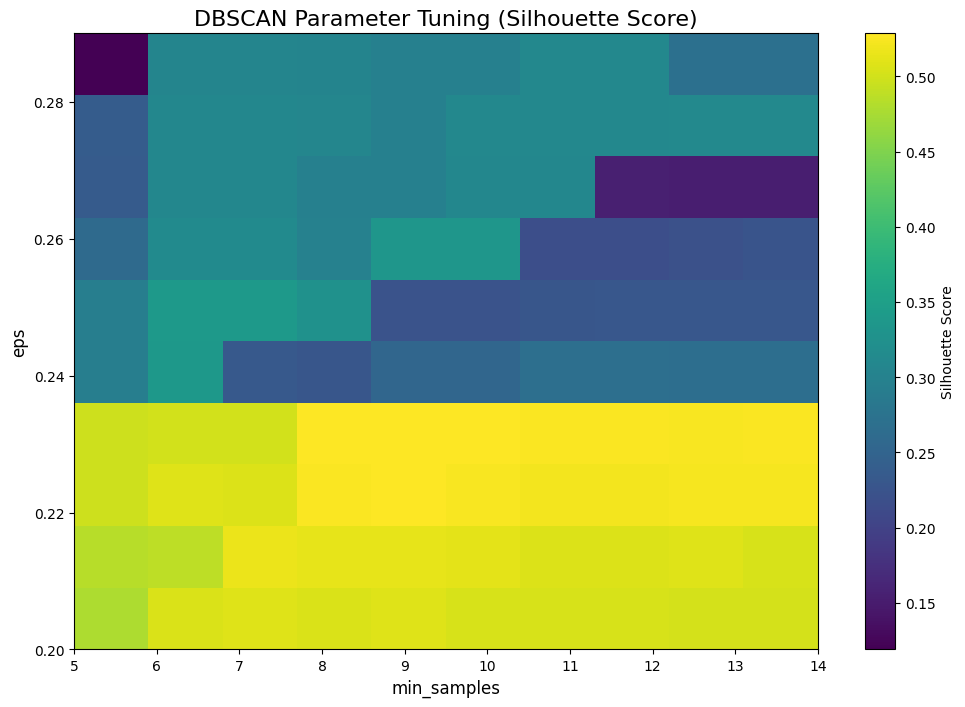

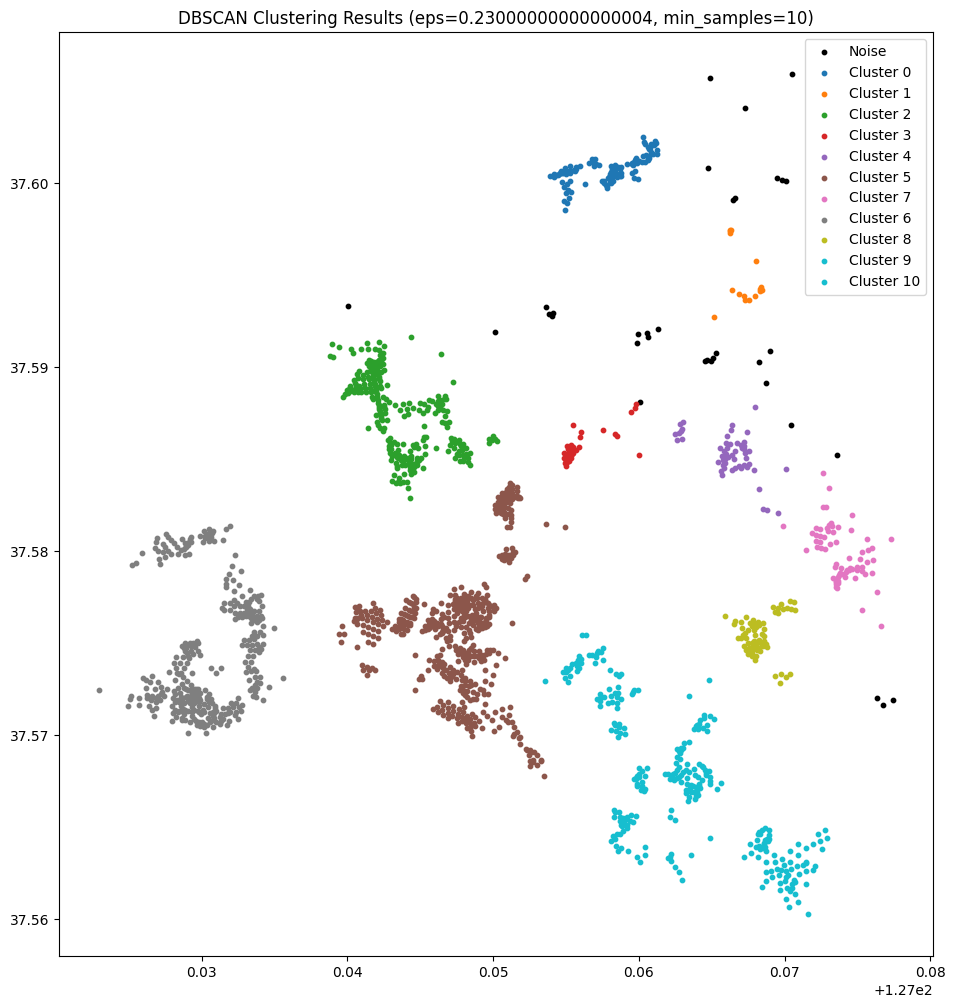

In [71]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.2, 0.3, 0.01)  # eps 범위
min_samples_values = range(5, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
foot_traffic_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = foot_traffic_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = foot_traffic_gdp[foot_traffic_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.34, Best min_samples: 11, Best silhouette score: 0.3723524542035232


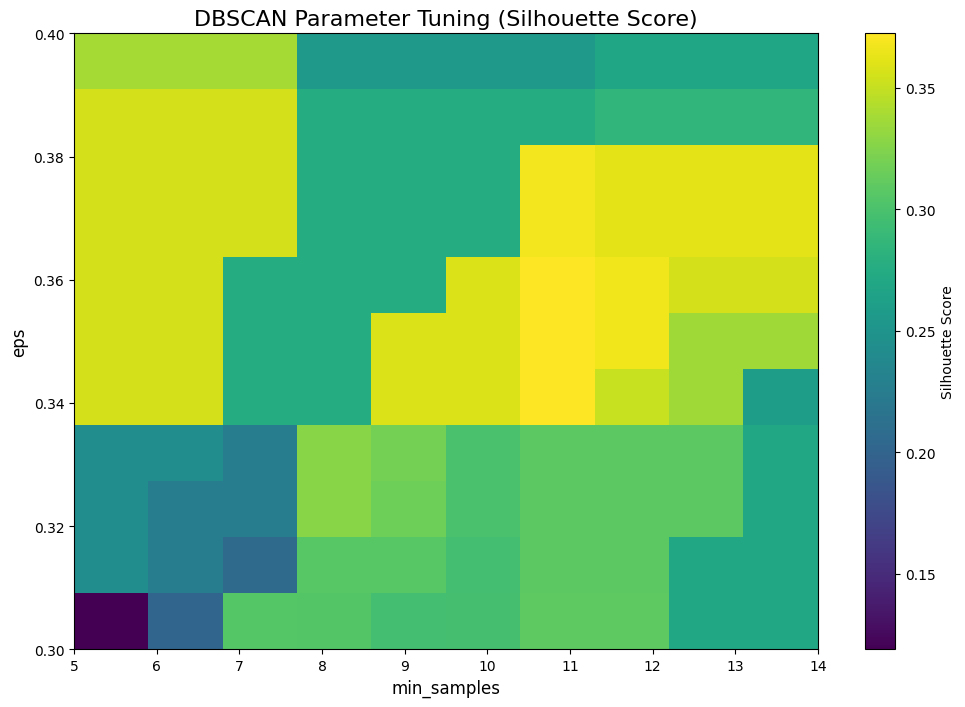

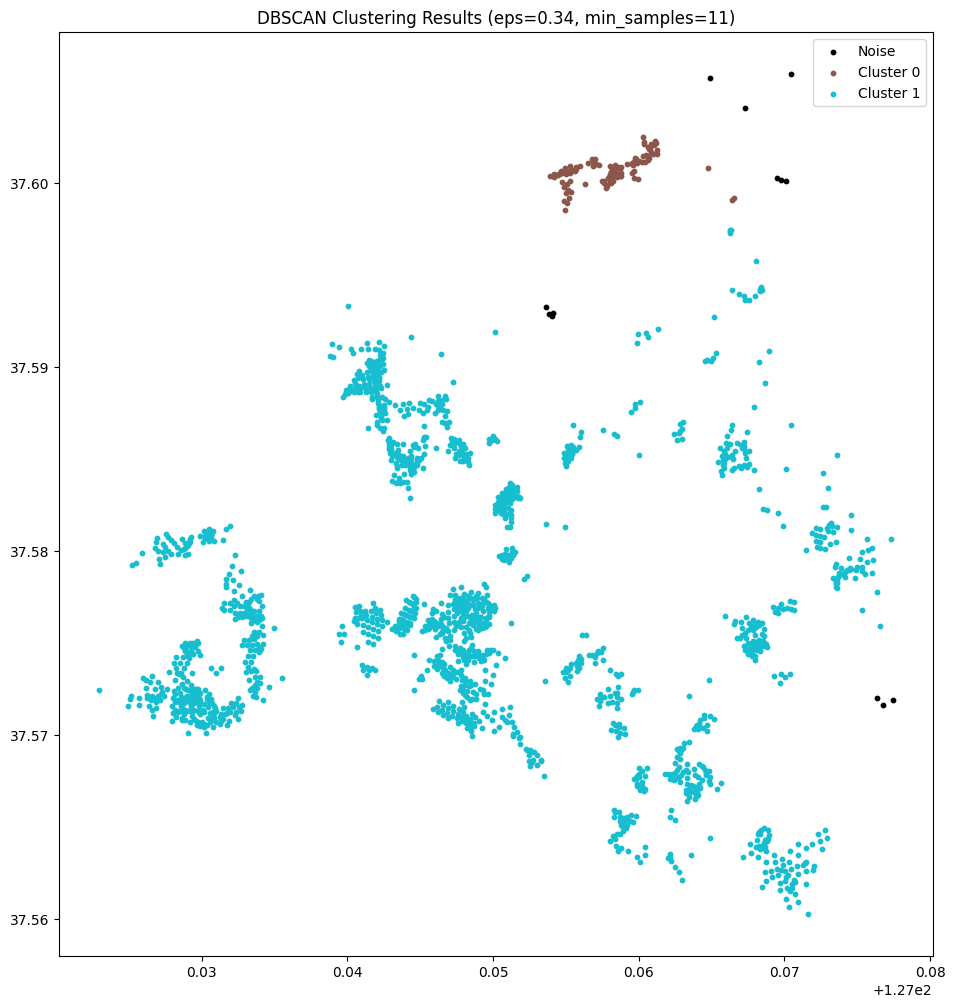

In [72]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.3, 0.4, 0.01)  # eps 범위
min_samples_values = range(5, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
foot_traffic_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = foot_traffic_gdp['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = foot_traffic_gdp[foot_traffic_gdp['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


Best eps: 0.14999999999999997, Best min_samples: 5, Best silhouette score: 0.5381561782667941가 제일 괜찮아 보인다.

In [73]:
# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = 0.14999999999999997, 5
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
foot_traffic_gdp['cluster'] = dbscan.fit_predict(coords_scaled)

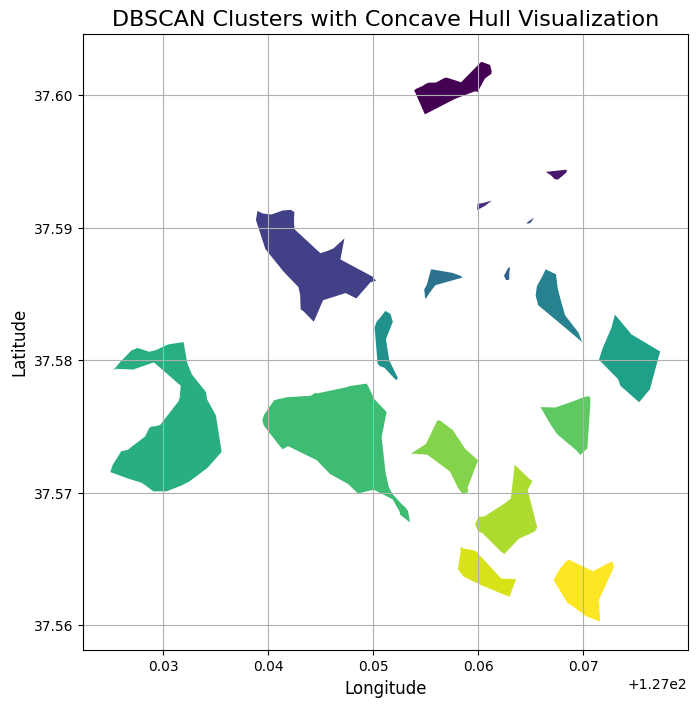

In [74]:
# Concave Hull 계산
cluster_rows = []

for cluster in foot_traffic_gdp['cluster'].unique():
    if cluster == -1:  # Noise는 제외
        continue

    # 특정 클러스터에 속하는 데이터 필터링
    cluster_data = foot_traffic_gdp[foot_traffic_gdp['cluster'] == cluster]

    # 해당 클러스터의 Concave Hull 계산
    coords = list(zip(cluster_data.geometry.x, cluster_data.geometry.y))

    # Alpha Shape을 사용하여 Concave Hull 생성
    concave_hull = alphashape.alphashape(coords, alpha=500)  # alpha 값 조정 가능

    # Concave Hull 정보 저장
    cluster_rows.append({'cluster': cluster, 'geometry': concave_hull})

# Concave Hull을 포함한 GeoDataFrame 생성
gdf_clusters = gpd.GeoDataFrame(cluster_rows, columns=['cluster', 'geometry'], crs=foot_traffic_gdp.crs)

# Concave Hull geometries 시각화
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_clusters.plot(ax=ax, cmap='viridis', legend=True)
plt.title('DBSCAN Clusters with Concave Hull Visualization', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True)
plt.show()


In [75]:
output_path = "/content/drive/MyDrive/bigdata/dataset/전처리 완료/유동인구 dbscan.geojson"
gdf_clusters.to_file(output_path, driver="GeoJSON")